In [ ]:
!pip install hvplot holoviews bokeh
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import hvplot.pandas
import holoviews as hv
hv.extension('bokeh')

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler


from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, roc_curve, auc,
    ConfusionMatrixDisplay, RocCurveDisplay # Updated import
)
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

pd.set_option('display.float', '{:.2f}'.format)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.4/155.4 kB 3.2 MB/s eta 0:00:00


In [ ]:
data = pd.read_csv("/content/lending_club_loan_two.csv")
data.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.00,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.00,Not Verified,Jan-2015,Fully Paid,vacation,Vacation,26.24,Jun-1990,16.00,0.00,36369.00,41.80,25.00,w,INDIVIDUAL,0.00,0.00,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000.00,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.00,Not Verified,Jan-2015,Fully Paid,debt_consolidation,Debt consolidation,22.05,Jul-2004,17.00,0.00,20131.00,53.30,27.00,f,INDIVIDUAL,3.00,0.00,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600.00,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.00,Source Verified,Jan-2015,Fully Paid,credit_card,Credit card refinancing,12.79,Aug-2007,13.00,0.00,11987.00,92.20,26.00,f,INDIVIDUAL,0.00,0.00,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,7200.00,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.00,Not Verified,Nov-2014,Fully Paid,credit_card,Credit card refinancing,2.60,Sep-2006,6.00,0.00,5472.00,21.50,13.00,f,INDIVIDUAL,0.00,0.00,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,24375.00,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.00,Verified,Apr-2013,Charged Off,credit_card,Credit Card Refinance,33.95,Mar-1999,13.00,0.00,24584.00,69.80,43.00,f,INDIVIDUAL,1.00,0.00,"679 Luna Roads\r\nGreggshire, VA 11650"


In [ ]:
data.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies
count,396030.00,396030.00,396030.00,396030.00,396030.00,396030.00,396030.00,396030.00,395754.00,396030.00,358235.00,395495.00
mean,14113.89,13.64,431.85,74203.18,17.38,11.31,0.18,15844.54,53.79,25.41,1.81,0.12
std,8357.44,4.47,250.73,61637.62,18.02,5.14,0.53,20591.84,24.45,11.89,2.15,0.36
min,500.00,5.32,16.08,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,0.00
25%,8000.00,10.49,250.33,45000.00,11.28,8.00,0.00,6025.00,35.80,17.00,0.00,0.00
50%,12000.00,13.33,375.43,64000.00,16.91,10.00,0.00,11181.00,54.80,24.00,1.00,0.00
75%,20000.00,16.49,567.30,90000.00,22.98,14.00,0.00,19620.00,72.90,32.00,3.00,0.00
max,40000.00,30.99,1533.81,8706582.00,9999.00,90.00,86.00,1743266.00,892.30,151.00,34.00,8.00


Exploratory Data Analysis



In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394274 non-null  object 
 15  


> Current status of the loan

In [ ]:
plot = data['loan_status'].value_counts().hvplot.bar(
    title="Loan Status Counts",
    xlabel='Loan Status',
    ylabel='Count',
    width=500,
    height=350
)
def dis(plot):
  return plot

dis(plot)
# Display the plot
#

:Bars   [loan_status]   (count)

<ipython-input-7-528ec0bd7a20>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette='viridis')


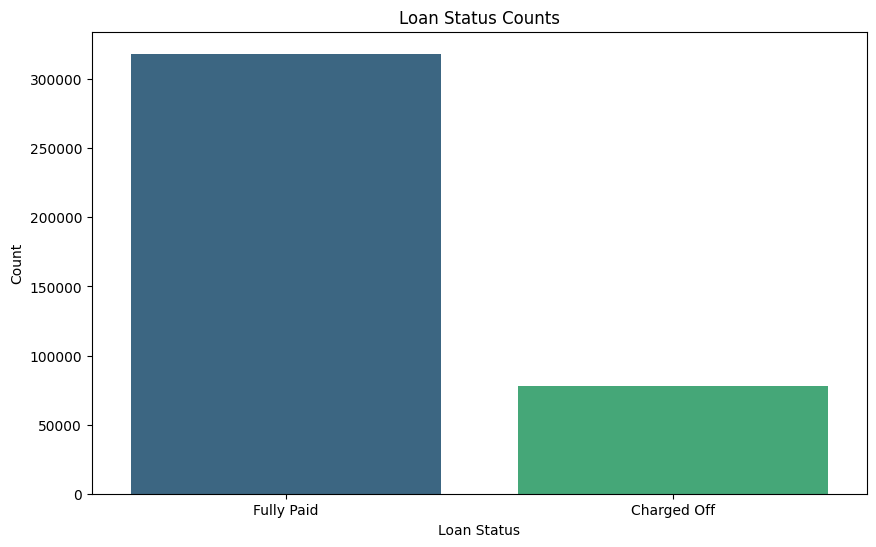

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count values
counts = data['loan_status'].value_counts()

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x=counts.index, y=counts.values, palette='viridis')
plt.title("Loan Status Counts")
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.show()

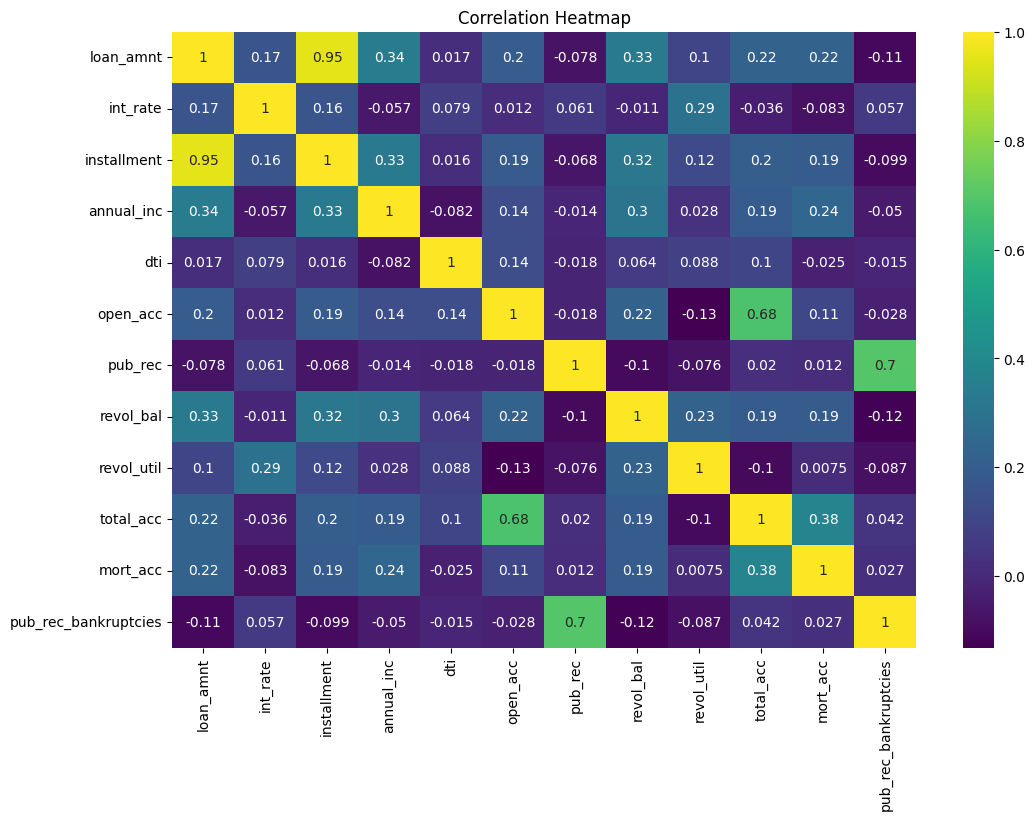

In [ ]:

plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(numeric_only=True), annot=True, cmap='viridis')
plt.title('Correlation Heatmap')
plt.show()

loan_amnt & installment



In [ ]:
installment = data.hvplot.hist(
    y='installment', by='loan_status', subplots=False,
    width=350, height=400, bins=50, alpha=0.4,
    title="Installment by Loan Status",
    xlabel='Installment', ylabel='Counts', legend='top'
)

loan_amnt = data.hvplot.hist(
    y='loan_amnt', by='loan_status', subplots=False,
    width=350, height=400, bins=30, alpha=0.4,
    title="Loan Amount by Loan Status",
    xlabel='Loan Amount', ylabel='Counts', legend='top'
)

installment + loan_amnt

:Layout
   .NdOverlay.I  :NdOverlay   [loan_status]
      :Histogram   [installment]   (installment_count)
   .NdOverlay.II :NdOverlay   [loan_status]
      :Histogram   [loan_amnt]   (loan_amnt_count)

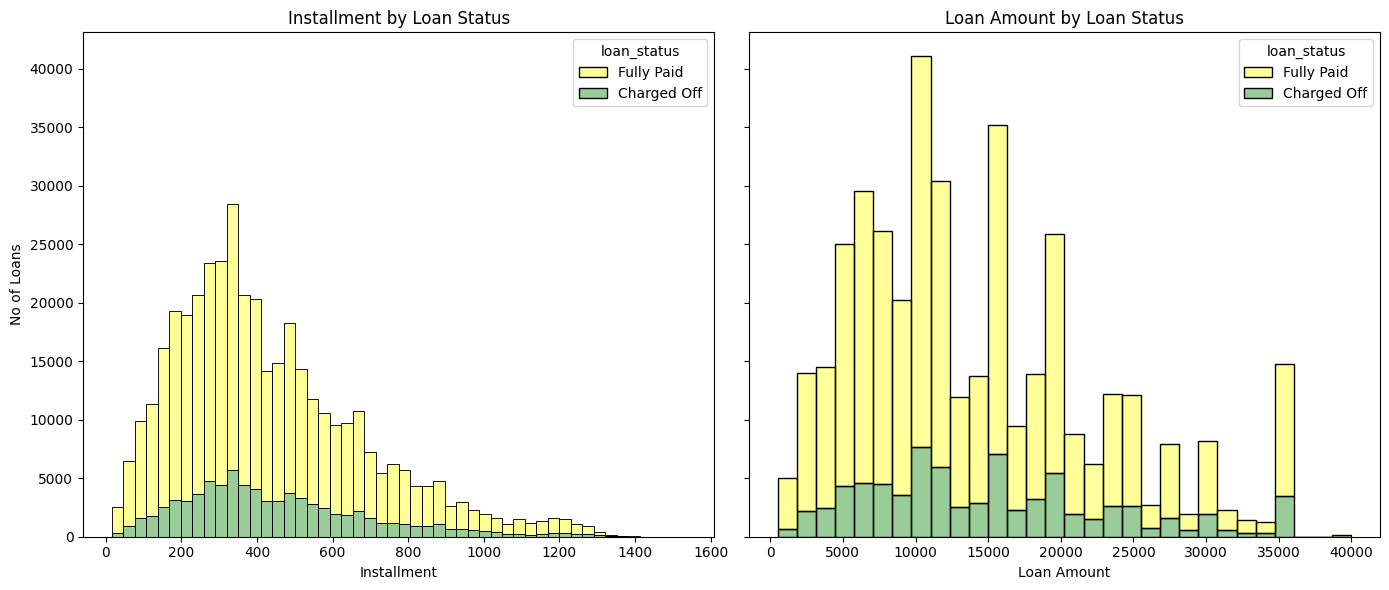

In [ ]:

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)


sns.histplot(data=data, x='installment', hue='loan_status', multiple='stack', bins=50, alpha=0.4,palette={'Charged Off': 'green', 'Fully Paid': 'yellow'} ,ax=axes[0])
axes[0].set_title("Installment by Loan Status")
axes[0].set_xlabel('Installment')
axes[0].set_ylabel('No of Loans')

sns.histplot(data=data, x='loan_amnt', hue='loan_status', multiple='stack', bins=30, alpha=0.4,palette={'Charged Off': 'green', 'Fully Paid': 'yellow'}, ax=axes[1])
axes[1].set_title("Loan Amount by Loan Status")
axes[1].set_xlabel('Loan Amount')
axes[1].set_ylabel('No of Loans')

plt.tight_layout()
plt.show()


<ipython-input-11-0baa4cb49d33>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='loan_status', y='loan_amnt', data=data, ax=axes[0], palette='viridis')
<ipython-input-11-0baa4cb49d33>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='loan_status', y='installment', data=data, ax=axes[1], palette='viridis')


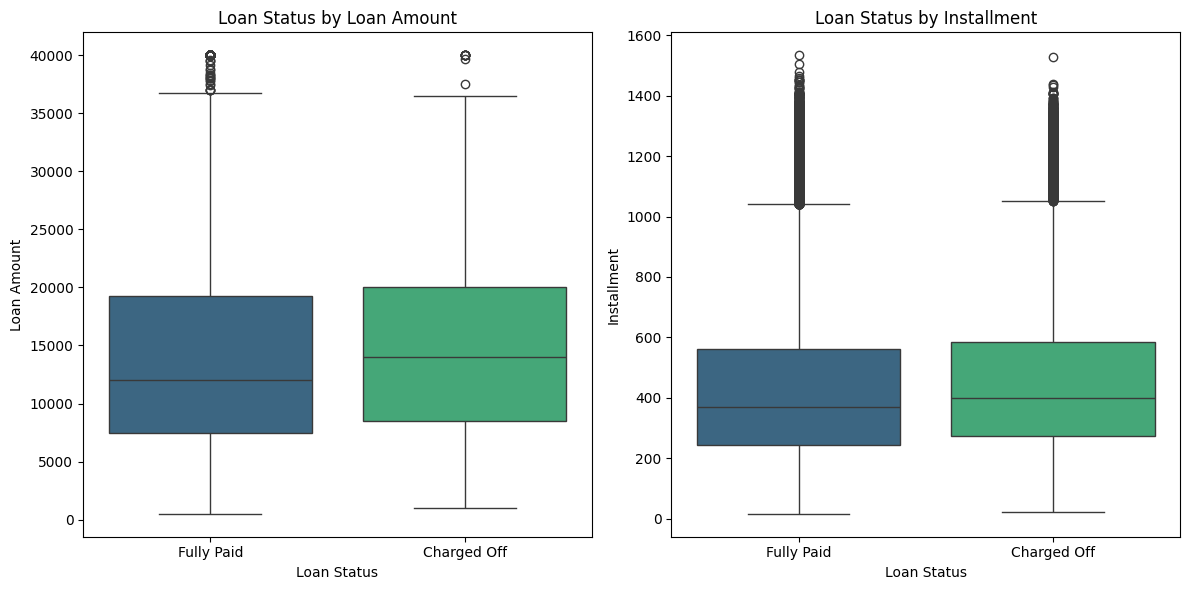

In [ ]:

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.boxplot(x='loan_status', y='loan_amnt', data=data, ax=axes[0], palette='viridis')
axes[0].set_title("Loan Status by Loan Amount")
axes[0].set_xlabel('Loan Status')
axes[0].set_ylabel('Loan Amount')


sns.boxplot(x='loan_status', y='installment', data=data, ax=axes[1], palette='viridis')
axes[1].set_title("Loan Status by Installment")
axes[1].set_xlabel('Loan Status')
axes[1].set_ylabel('Installment')


plt.tight_layout()
plt.show()


In [ ]:
data.groupby(by='loan_status')['loan_amnt'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,77673.00,15126.30,8505.09,1000.00,8525.00,14000.00,20000.00,40000.00
Fully Paid,318357.00,13866.88,8302.32,500.00,7500.00,12000.00,19225.00,40000.00


grade & sub_grade


In [ ]:
print(f"GRADE unique: {sorted(data.grade.unique())}")
print(f"SUB_GRADE unique: {sorted(data.sub_grade.unique())}")

GRADE unique: ['A', 'B', 'C', 'D', 'E', 'F', 'G']
SUB_GRADE unique: ['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5']


In [ ]:
fully_paid = data.loc[data['loan_status']=='Fully Paid', 'grade'].value_counts().hvplot.bar()
charged_off = data.loc[data['loan_status']=='Charged Off', 'grade'].value_counts().hvplot.bar()

(fully_paid * charged_off).opts(
    title="Loan Status by Grade", xlabel='Grades', ylabel='Count',
    width=500, height=450, legend_cols=2, legend_position='top_right', xrotation=90
)

:Overlay
   .Bars.Count.I  :Bars   [grade]   (count)
   .Bars.Count.II :Bars   [grade]   (count)

In [ ]:
fully_paid = data.loc[data['loan_status']=='Fully Paid', 'sub_grade'].value_counts().hvplot.bar()
charged_off = data.loc[data['loan_status']=='Charged Off', 'sub_grade'].value_counts().hvplot.bar()

(fully_paid * charged_off).opts(
    title="Loan Status by Grade", xlabel='Grades', ylabel='Count',
    width=500, height=400, legend_cols=2, legend_position='top_right', xrotation=90
)

:Overlay
   .Bars.Count.I  :Bars   [sub_grade]   (count)
   .Bars.Count.II :Bars   [sub_grade]   (count)

<ipython-input-16-1e16e844fde2>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90);


Text(0, 0.5, 'Number of Loans')

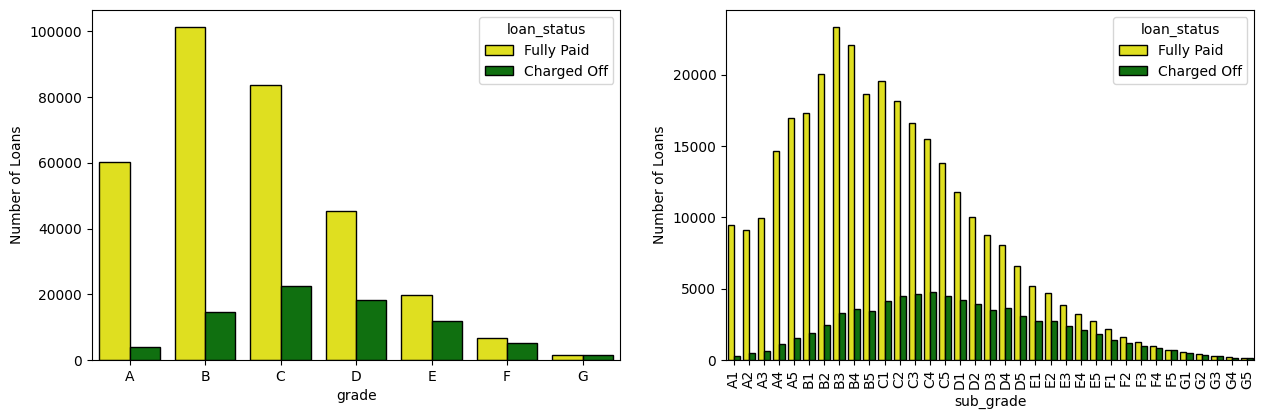

In [ ]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
grade = sorted(data.grade.unique().tolist())
sns.countplot(x='grade', data=data, hue='loan_status', order=grade, palette={'Charged Off': 'green', 'Fully Paid': 'yellow'},edgecolor='black')
plt.ylabel('Number of Loans')  # Rename Y-axis


plt.subplot(2, 2, 2)
sub_grade = sorted(data.sub_grade.unique().tolist())
g = sns.countplot(x='sub_grade', data=data, hue='loan_status', order=sub_grade, palette={'Charged Off': 'green', 'Fully Paid': 'yellow'}, edgecolor='black')
g.set_xticklabels(g.get_xticklabels(), rotation=90);
plt.ylabel('Number of Loans')  # Rename Y-axis

Text(0, 0.5, 'Number of Loans')

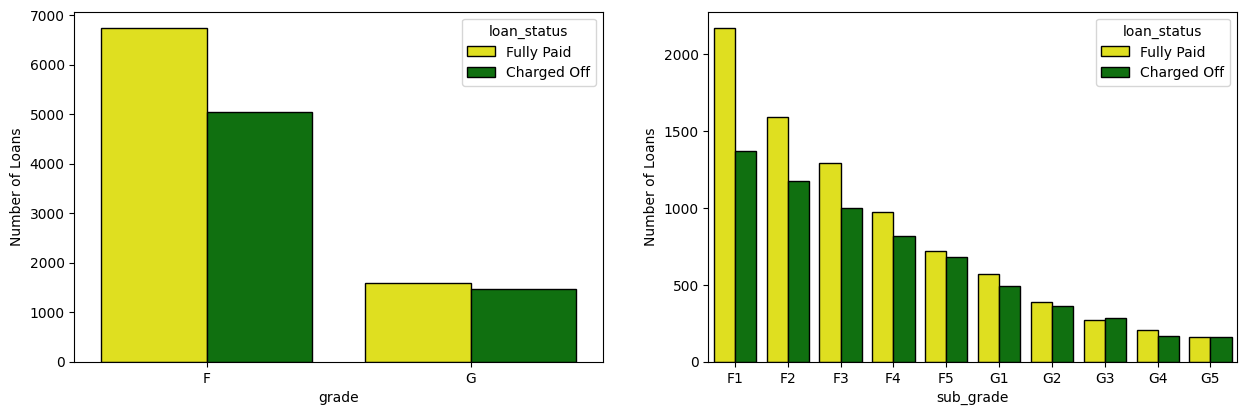

In [ ]:
df = data[(data.grade == 'F') | (data.grade == 'G')]

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
grade = sorted(df.grade.unique().tolist())
sns.countplot(x='grade', data=df, hue='loan_status', palette={'Charged Off': 'green', 'Fully Paid': 'yellow'},edgecolor='black', order=grade)
plt.ylabel('Number of Loans')  # Rename Y-axis

plt.subplot(2, 2, 2)
sub_grade = sorted(df.sub_grade.unique().tolist())
sns.countplot(x='sub_grade', data=df, hue='loan_status', palette={'Charged Off': 'green', 'Fully Paid': 'yellow'},edgecolor='black', order=sub_grade)
plt.ylabel('Number of Loans')  # Rename Y-axis

In [ ]:
data['home_ownership'].value_counts()

,count
home_ownership,
MORTGAGE,198348
RENT,159790
OWN,37746
OTHER,112
NONE,31
ANY,3


In [ ]:
fully_paid = data.loc[data['loan_status']=='Fully Paid', 'home_ownership'].value_counts().hvplot.bar()
charged_off = data.loc[data['loan_status']=='Charged Off', 'home_ownership'].value_counts().hvplot.bar()

home_ownership_count = (fully_paid * charged_off).opts(
    title="Loan Status by Grade", xlabel='Home Ownership', ylabel='Count',
    width=350, height=350, legend_cols=2, legend_position='top_right'
).opts(xrotation=90)

home_ownership = data.home_ownership.value_counts().hvplot.bar(
    title="Loan Status by Grade", xlabel='Home Ownership', ylabel='Count',
    width=350, height=350, legend='top'
).opts(xrotation=90)

(home_ownership_count + home_ownership)

:Layout
   .Overlay.Count :Overlay
      .Bars.Count.I  :Bars   [home_ownership]   (count)
      .Bars.Count.II :Bars   [home_ownership]   (count)
   .Bars.Count    :Bars   [home_ownership]   (count)

In [ ]:
data.loc[(data.home_ownership == 'ANY') | (data.home_ownership == 'NONE'), 'home_ownership'] = 'OTHER'
data.home_ownership.value_counts()

,count
home_ownership,
MORTGAGE,198348
RENT,159790
OWN,37746
OTHER,146


<ipython-input-21-b649bfc9cb8c>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90);


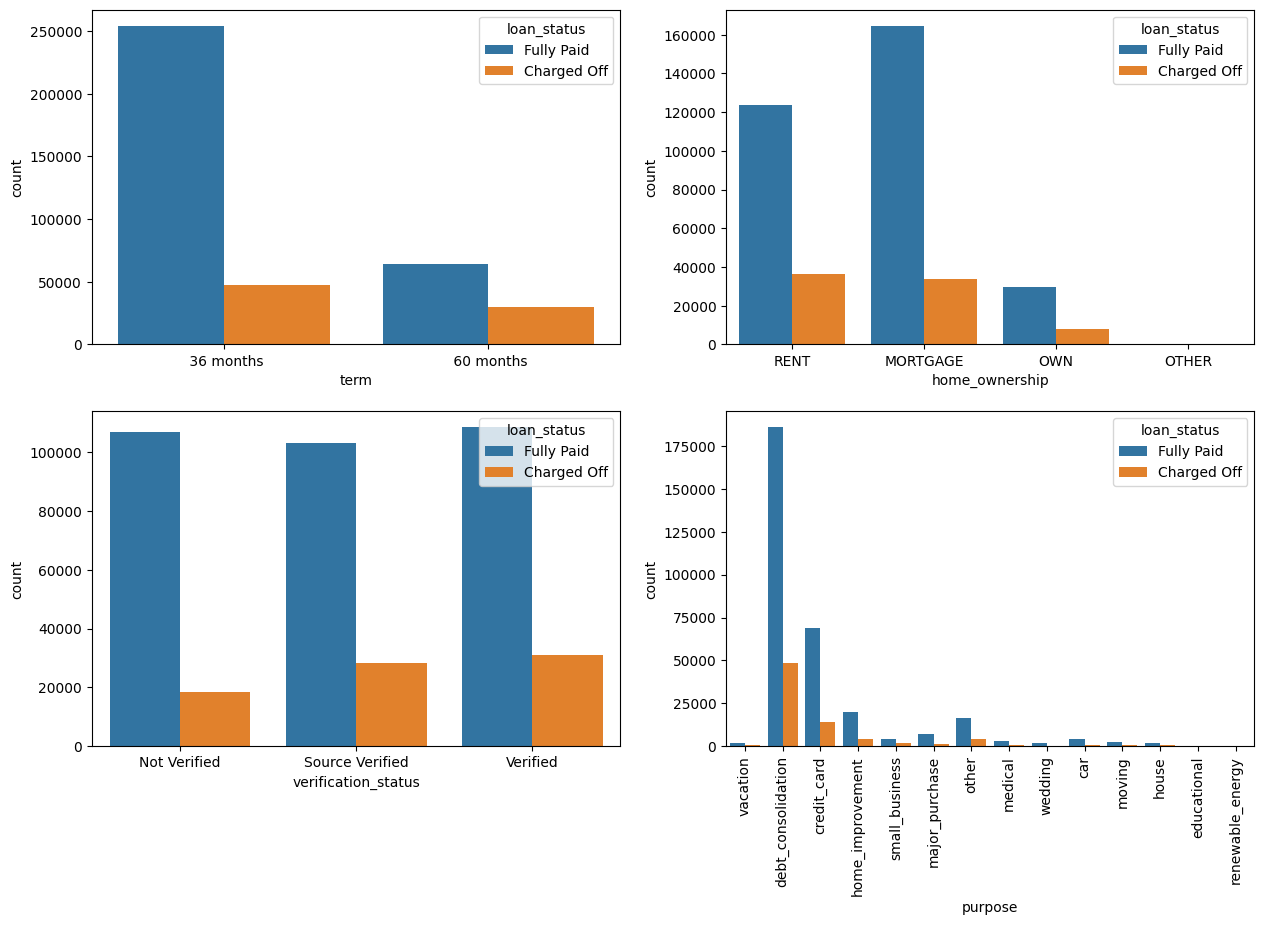

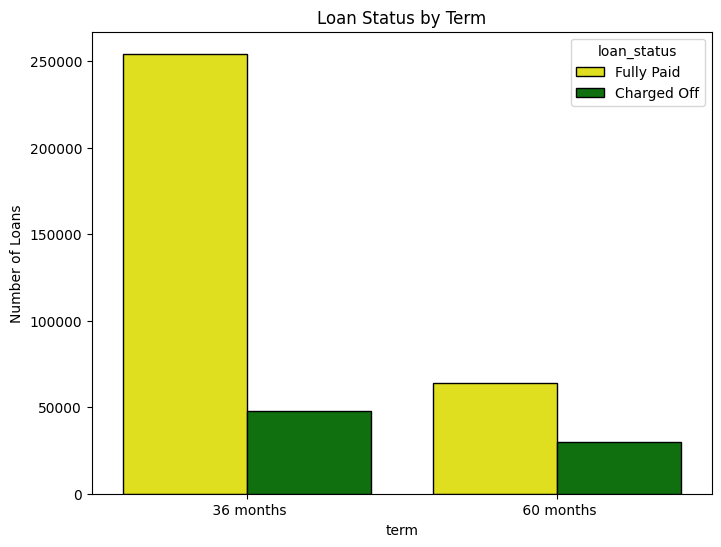

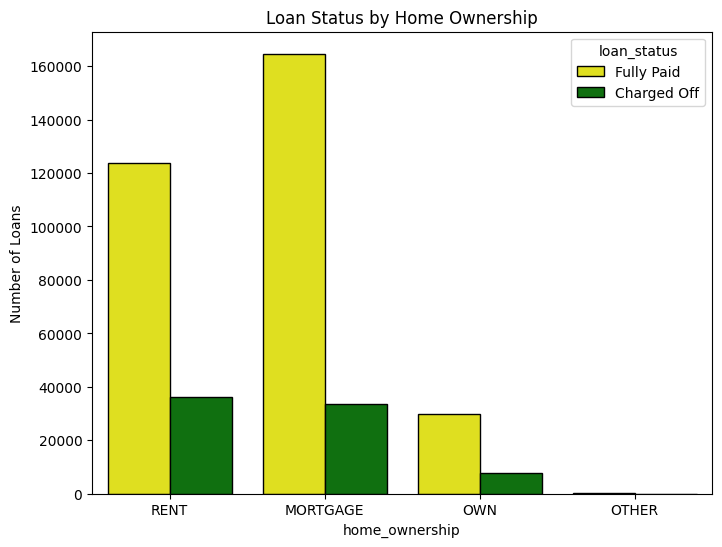

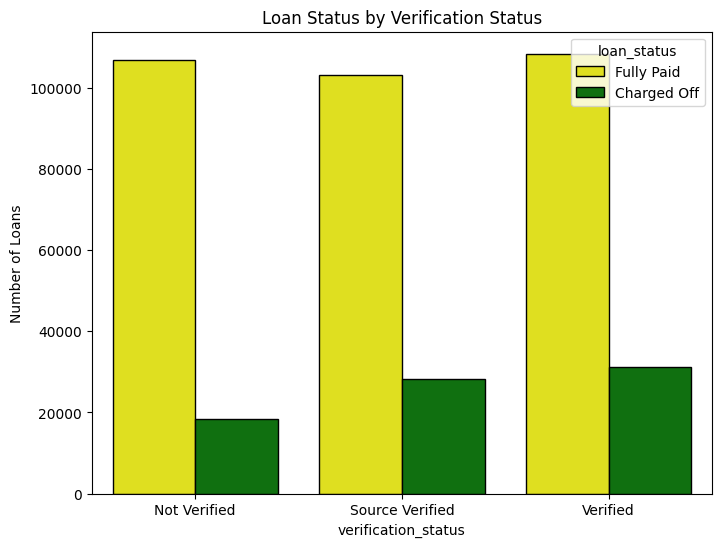

<ipython-input-21-b649bfc9cb8c>:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90)


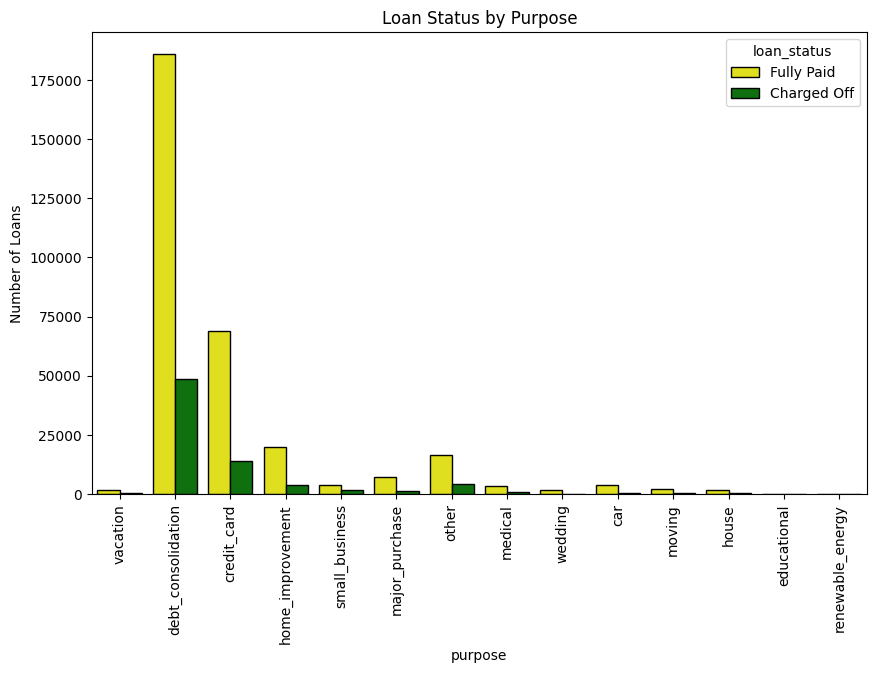

In [ ]:
plt.figure(figsize=(15, 20))

plt.subplot(4, 2, 1)
sns.countplot(x='term', data=data, hue='loan_status')

plt.subplot(4, 2, 2)
sns.countplot(x='home_ownership', data=data, hue='loan_status')

plt.subplot(4, 2, 3)
sns.countplot(x='verification_status', data=data, hue='loan_status')

plt.subplot(4, 2, 4)
g = sns.countplot(x='purpose', data=data, hue='loan_status')
g.set_xticklabels(g.get_xticklabels(), rotation=90);


palette_colors = {'Charged Off': 'green', 'Fully Paid': 'yellow'}


plt.figure(figsize=(8, 6))
sns.countplot(x='term', data=data, hue='loan_status', palette=palette_colors, edgecolor='black')
plt.title('Loan Status by Term')
plt.ylabel('Number of Loans')
plt.show()


plt.figure(figsize=(8, 6))
sns.countplot(x='home_ownership', data=data, hue='loan_status', palette=palette_colors, edgecolor='black')
plt.title('Loan Status by Home Ownership')
plt.ylabel('Number of Loans')
plt.show()

plt.figure(figsize=(8, 6))
sns.countplot(x='verification_status', data=data, hue='loan_status', palette=palette_colors, edgecolor='black')
plt.title('Loan Status by Verification Status')
plt.ylabel('Number of Loans')
plt.show()


plt.figure(figsize=(10, 6))
g = sns.countplot(x='purpose', data=data, hue='loan_status', palette=palette_colors, edgecolor='black')
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.title('Loan Status by Purpose')
plt.ylabel('Number of Loans')
plt.show()

In [ ]:
data.loc[data['home_ownership']=='OTHER', 'loan_status'].value_counts()

,count
loan_status,
Fully Paid,123
Charged Off,23


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
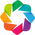

:NdOverlay   [loan_status]
   :Histogram   [annual_inc]   (annual_inc_count)

In [ ]:
import hvplot.pandas
import holoviews as hv
hv.extension('bokeh')


int_rate = data.hvplot.hist(
    y='int_rate', by='loan_status', alpha=0.3, width=550, height=600,
    title="Loan Status by Interest Rate", xlabel='Interest Rate', ylabel='No of Loans',
    legend='top',color=['green', 'yellow'], line_color='black'
)
int_rate
annual_inc = data.hvplot.hist(
    y='annual_inc', by='loan_status', bins=50, alpha=0.3, width=350, height=400,
    title="Loan Status by Annual Income", xlabel='Annual Income', ylabel='Loans Counts',
    legend='top',color=['green', 'yellow'], line_color='black'
).opts(xrotation=45)
annual_inc

In [ ]:
test = data[data.annual_inc <= 250000].hvplot.hist(
    y='annual_inc', by='loan_status', bins=50, alpha=0.3, width=500, height=400,
    title="Loan Status by Annual Income (<= 250000/Year)",
    xlabel='Annual Income', ylabel='Loans Counts', legend='top'
).opts(xrotation=45)
test


:NdOverlay   [loan_status]
   :Histogram   [annual_inc]   (annual_inc_count)

In [ ]:
print((data[data.annual_inc >= 250000].shape[0] / data.shape[0]) * 100)
print((data[data.annual_inc >= 1000000].shape[0] / data.shape[0]) * 100)

1.0294674645860162
0.018937959245511705


In [ ]:
data.loc[data.annual_inc >= 1000000, 'loan_status'].value_counts()

,count
loan_status,
Fully Paid,65
Charged Off,10


In [ ]:
data.loc[data.annual_inc >= 250000, 'loan_status'].value_counts()

,count
loan_status,
Fully Paid,3509
Charged Off,568


In [ ]:
print(data.emp_title.isna().sum())
print(data.emp_title.nunique())

22927
173105


In [ ]:
data['emp_title'].value_counts()[:20]

,count
emp_title,
Teacher,4389
Manager,4250
Registered Nurse,1856
RN,1846
Supervisor,1830
Sales,1638
Project Manager,1505
Owner,1410
Driver,1339


<ipython-input-30-34ebc1631d63>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90);


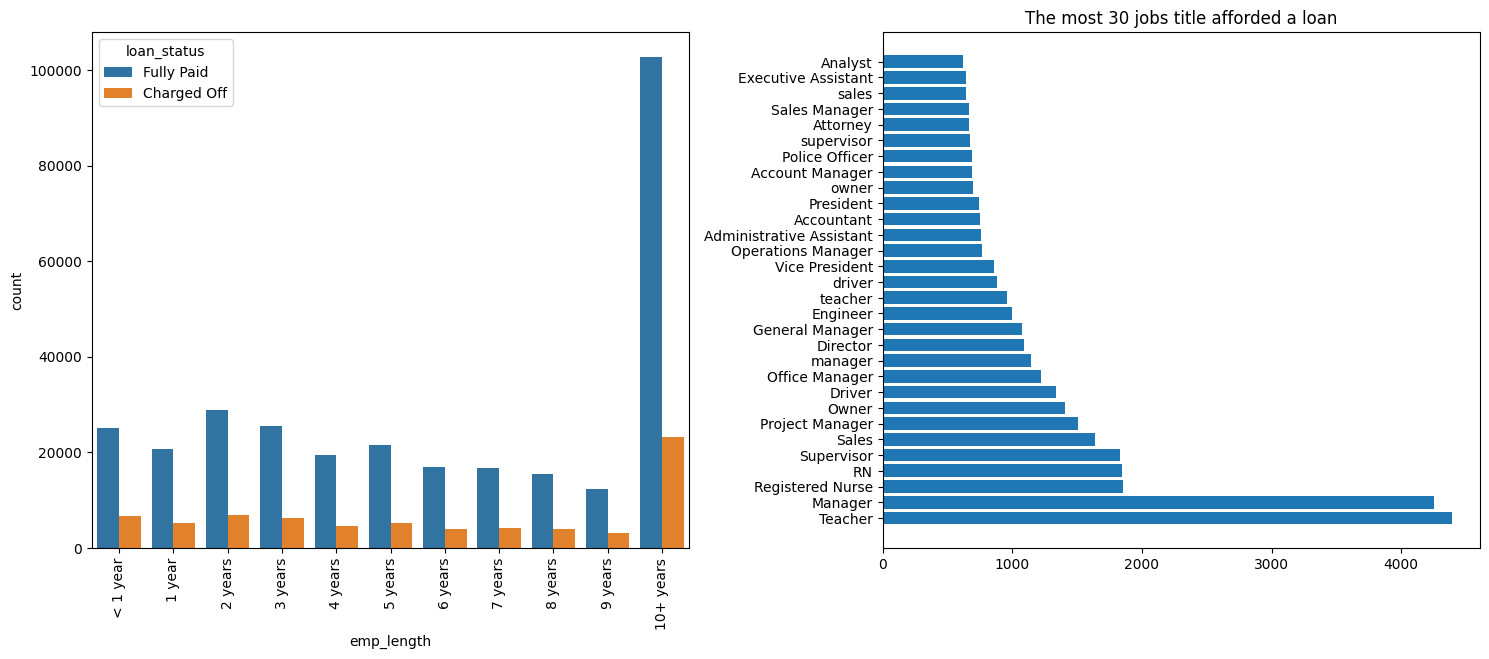

In [ ]:
plt.figure(figsize=(15, 12))

plt.subplot(2, 2, 1)
order = ['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years',
          '6 years', '7 years', '8 years', '9 years', '10+ years',]
g = sns.countplot(x='emp_length', data=data, hue='loan_status', order=order)
g.set_xticklabels(g.get_xticklabels(), rotation=90);

plt.subplot(2, 2, 2)
plt.barh(data.emp_title.value_counts()[:30].index, data.emp_title.value_counts()[:30])
plt.title("The most 30 jobs title afforded a loan")
plt.tight_layout()

In [ ]:
# data.hvplot.line(x='issue_d', y='loan_status')

In [ ]:
data['earliest_cr_line'].value_counts()

,count
earliest_cr_line,
Oct-2000,3017
Aug-2000,2935
Oct-2001,2896
Aug-2001,2884
Nov-2000,2736
...,...
Jul-1958,1
Nov-1957,1
Jan-1953,1


In [ ]:
data['issue_d'] = pd.to_datetime(data['issue_d'])
data['earliest_cr_line'] = pd.to_datetime(data['earliest_cr_line'])

<ipython-input-33-2f9ecc54f8c2>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['issue_d'] = pd.to_datetime(data['issue_d'])
<ipython-input-33-2f9ecc54f8c2>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['earliest_cr_line'] = pd.to_datetime(data['earliest_cr_line'])


In [ ]:
fully_paid = data.loc[data['loan_status']=='Fully Paid', 'issue_d'].hvplot.hist(bins=35)
charged_off = data.loc[data['loan_status']=='Charged Off', 'issue_d'].hvplot.hist(bins=35)

# fully_paid * charged_off
loan_issue_date = (fully_paid * charged_off).opts(
    title="Loan Status by Loan Issue Date", xlabel='Loan Issue Date', ylabel='Count',
    width=350, height=350, legend_cols=2, legend_position='top_right'
).opts(xrotation=45)

fully_paid = data.loc[data['loan_status']=='Fully Paid', 'earliest_cr_line'].hvplot.hist(bins=35)
charged_off = data.loc[data['loan_status']=='Charged Off', 'earliest_cr_line'].hvplot.hist(bins=35)

earliest_cr_line = (fully_paid * charged_off).opts(
    title="Loan Status by earliest_cr_line", xlabel='earliest_cr_line', ylabel='Count',
    width=350, height=350, legend_cols=2, legend_position='top_right'
).opts(xrotation=45)

loan_issue_date + earliest_cr_line

:Layout
   .Overlay.I  :Overlay
      .Histogram.I  :Histogram   [issue_d]   (issue_d_count)
      .Histogram.II :Histogram   [issue_d]   (issue_d_count)
   .Overlay.II :Overlay
      .Histogram.I  :Histogram   [earliest_cr_line]   (earliest_cr_line_count)
      .Histogram.II :Histogram   [earliest_cr_line]   (earliest_cr_line_count)

title


In [ ]:
data.title.isna().sum()

1756

In [ ]:
data['title'] = data.title.str.lower()

In [ ]:
data.title.value_counts()[:10]

,count
title,
debt consolidation,168108
credit card refinancing,51781
home improvement,17117
other,12993
consolidation,5583
major purchase,4998
debt consolidation loan,3513
business,3017
medical expenses,2820


In [ ]:
data.dti.value_counts()

,count
dti,
0.00,313
14.40,310
19.20,302
16.80,301
18.00,300
...,...
59.18,1
48.37,1
45.71,1


In [ ]:
dti = data.hvplot.hist(
    y='dti', bins=50, width=350, height=350,
    title="dti Distribution", xlabel='dti', ylabel='Count'
)

sub_dti = data[data['dti']<=50].hvplot.hist(
    y='dti', bins=50, width=350, height=350,
    title="dti (<=30) Distribution", xlabel='dti', ylabel='Count', shared_axes=False
)

dti + sub_dti

:Layout
   .Histogram.I  :Histogram   [dti]   (dti_count)
   .Histogram.II :Histogram   [dti]   (dti_count)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
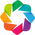

:NdOverlay   [loan_status]
   :Histogram   [dti]   (dti_count)

In [ ]:
import hvplot.pandas
import holoviews as hv
hv.extension('bokeh')

# Plotting the histogram for interest rate
sub_dti = data[data['dti']<=50].hvplot.hist(
     y='dti', by='loan_status', alpha=0.3, width=550, height=600,
    title="dti (<=30) Distribution", xlabel='dti', ylabel='No of Loans',
    legend='top',color=['green', 'yellow'], line_color='black'
)
sub_dti


In [ ]:
print(data[data['dti']>=40].shape)

(296, 27)


In [ ]:
data.loc[data['dti']>=50, 'loan_status'].value_counts()

,count
loan_status,
Fully Paid,26
Charged Off,9


In [ ]:
dti = data[data['dti']<=50].hvplot.hist(
    y='dti', by='loan_status', bins=50, width=300, height=350,
    title="dti (<=30) Distribution", xlabel='dti', ylabel='Count',
    alpha=0.3, legend='top'
)

title="Loan Status by The number of open credit lines"

open_acc = data.hvplot.hist(
    y='open_acc', by='loan_status', bins=50, width=300, height=350,
    title=title, xlabel='The number of open credit lines', ylabel='Count',
    alpha=0.4, legend='top'
)

title="Loan Status by The total number of credit lines"

total_acc = data.hvplot.hist(
    y='total_acc', by='loan_status', bins=50, width=300, height=350,
    title=title, xlabel='The total number of credit lines', ylabel='Count',
    alpha=0.4, legend='top'
)

dti + open_acc + total_acc

:Layout
   .NdOverlay.I   :NdOverlay   [loan_status]
      :Histogram   [dti]   (dti_count)
   .NdOverlay.II  :NdOverlay   [loan_status]
      :Histogram   [open_acc]   (open_acc_count)
   .NdOverlay.III :NdOverlay   [loan_status]
      :Histogram   [total_acc]   (total_acc_count)

In [ ]:
print(data.shape)
print(data[data.open_acc > 40].shape)

(396030, 27)
(217, 27)


In [ ]:
print(data.shape)
print(data[data.total_acc > 80].shape)

(396030, 27)
(266, 27)


In [ ]:
print(data.shape)
print(data[data.revol_util > 120].shape)

(396030, 27)
(27, 27)


In [ ]:
title="Loan Status by Revolving line utilization rate"

revol_util = data.hvplot.hist(
    y='revol_util', by='loan_status', bins=50, width=350, height=400,
    title=title, xlabel='Revolving line utilization rate', ylabel='Count',
    alpha=0.4, legend='top'
)

title="Loan Status by Revolving line utilization rate (<120)"

sub_revol_util = data[data.revol_util < 120].hvplot.hist(
    y='revol_util', by='loan_status', bins=50, width=350, height=400,
    title=title, xlabel='Revolving line utilization rate', ylabel='Count',
    shared_axes=False, alpha=0.4, legend='top'
)

revol_util + sub_revol_util

:Layout
   .NdOverlay.I  :NdOverlay   [loan_status]
      :Histogram   [revol_util]   (revol_util_count)
   .NdOverlay.II :NdOverlay   [loan_status]
      :Histogram   [revol_util]   (revol_util_count)

In [ ]:
data[data.revol_util > 200]

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
137211,3500.00,36 months,12.49,117.08,B,B4,Budget Analyst,10+ years,RENT,45000.00,Verified,2014-04-01,Fully Paid,debt_consolidation,debt consolidation,14.67,1998-10-01,2.00,0.00,2677.00,892.30,9.00,f,INDIVIDUAL,0.00,0.00,"12506 Connie Burg\r\nVelasquezfort, TN 00813"


In [ ]:
print(data.shape)
print(data[data.revol_bal > 250000].shape)

(396030, 27)
(397, 27)


In [ ]:
title = "Loan Status by Total credit revolving balance"

revol_bal = data.hvplot.hist(
    y='revol_bal', by='loan_status', bins=50, width=350, height=400,
    title=title, xlabel='Total credit revolving balance', ylabel='Count',
    alpha=0.4, legend='top'
)

title = "Loan Status by Total credit revolving balance (<250000)"

sub_revol_bal = data[data['revol_bal']<=250000].hvplot.hist(
    y='revol_bal', by='loan_status', bins=50, width=350, height=400,
    title=title, xlabel='Total credit revolving balance', ylabel='Count',
    alpha=0.4, legend='top', shared_axes=False
).opts(xrotation=45)

revol_bal + sub_revol_bal

:Layout
   .NdOverlay.I  :NdOverlay   [loan_status]
      :Histogram   [revol_bal]   (revol_bal_count)
   .NdOverlay.II :NdOverlay   [loan_status]
      :Histogram   [revol_bal]   (revol_bal_count)

In [ ]:
data.loc[data.revol_bal > 250000, 'loan_status'].value_counts()

,count
loan_status,
Fully Paid,351
Charged Off,46


In [ ]:
xlabel = 'Number of derogatory public records'
title = "Loan Status by Number of derogatory public records"

fully_paid = data.loc[data['loan_status']=='Fully Paid', 'pub_rec'].value_counts().hvplot.bar()
charged_off = data.loc[data['loan_status']=='Charged Off', 'pub_rec'].value_counts().hvplot.bar()

(fully_paid * charged_off).opts(
    title=title, xlabel=xlabel, ylabel='Count',
    width=400, height=400, legend_cols=2, legend_position='top_right'
)

:Overlay
   .Bars.Count.I  :Bars   [pub_rec]   (count)
   .Bars.Count.II :Bars   [pub_rec]   (count)

In [ ]:
xlabel = "The initial listing status of the loan"
title = "Loan Status by The initial listing status of the loan"

fully_paid = data.loc[data['loan_status']=='Fully Paid', 'initial_list_status'].value_counts().hvplot.bar()
charged_off = data.loc[data['loan_status']=='Charged Off', 'initial_list_status'].value_counts().hvplot.bar()

(fully_paid * charged_off).opts(
    title=title, xlabel=xlabel, ylabel='Count',
    width=400, height=400, legend_cols=2, legend_position='top_right'
)

:Overlay
   .Bars.Count.I  :Bars   [initial_list_status]   (count)
   .Bars.Count.II :Bars   [initial_list_status]   (count)

In [ ]:
fully_paid = data.loc[data['loan_status']=='Fully Paid', 'application_type'].value_counts().hvplot.bar()
charged_off = data.loc[data['loan_status']=='Charged Off', 'application_type'].value_counts().hvplot.bar()

(fully_paid * charged_off).opts(
    title="Loan Status by Application Type", xlabel="Application Type", ylabel='Count',
    width=400, height=400, legend_cols=2, legend_position='top_right'
)

:Overlay
   .Bars.Count.I  :Bars   [application_type]   (count)
   .Bars.Count.II :Bars   [application_type]   (count)

In [ ]:
xlabel = "Number of public record bankruptcies"
title = "Loan Status by The Number of public record bankruptcies"

fully_paid = data.loc[data['loan_status']=='Fully Paid', 'pub_rec_bankruptcies'].value_counts().hvplot.bar()
charged_off = data.loc[data['loan_status']=='Charged Off', 'pub_rec_bankruptcies'].value_counts().hvplot.bar()

(fully_paid * charged_off).opts(
    title=title, xlabel=xlabel, ylabel='Count',
    width=400, height=400, legend_cols=2, legend_position='top_right'
)

:Overlay
   .Bars.Count.I  :Bars   [pub_rec_bankruptcies]   (count)
   .Bars.Count.II :Bars   [pub_rec_bankruptcies]   (count)

In [ ]:
def pub_rec(number):
    if number == 0.0:
        return 0
    else:
        return 1

def mort_acc(number):
    if number == 0.0:
        return 0
    elif number >= 1.0:
        return 1
    else:
        return number

def pub_rec_bankruptcies(number):
    if number == 0.0:
        return 0
    elif number >= 1.0:
        return 1
    else:
        return number

In [ ]:
data['pub_rec'] = data.pub_rec.apply(pub_rec)
data['mort_acc'] = data.mort_acc.apply(mort_acc)
data['pub_rec_bankruptcies'] = data.pub_rec_bankruptcies.apply(pub_rec_bankruptcies)

<Axes: xlabel='pub_rec_bankruptcies', ylabel='count'>

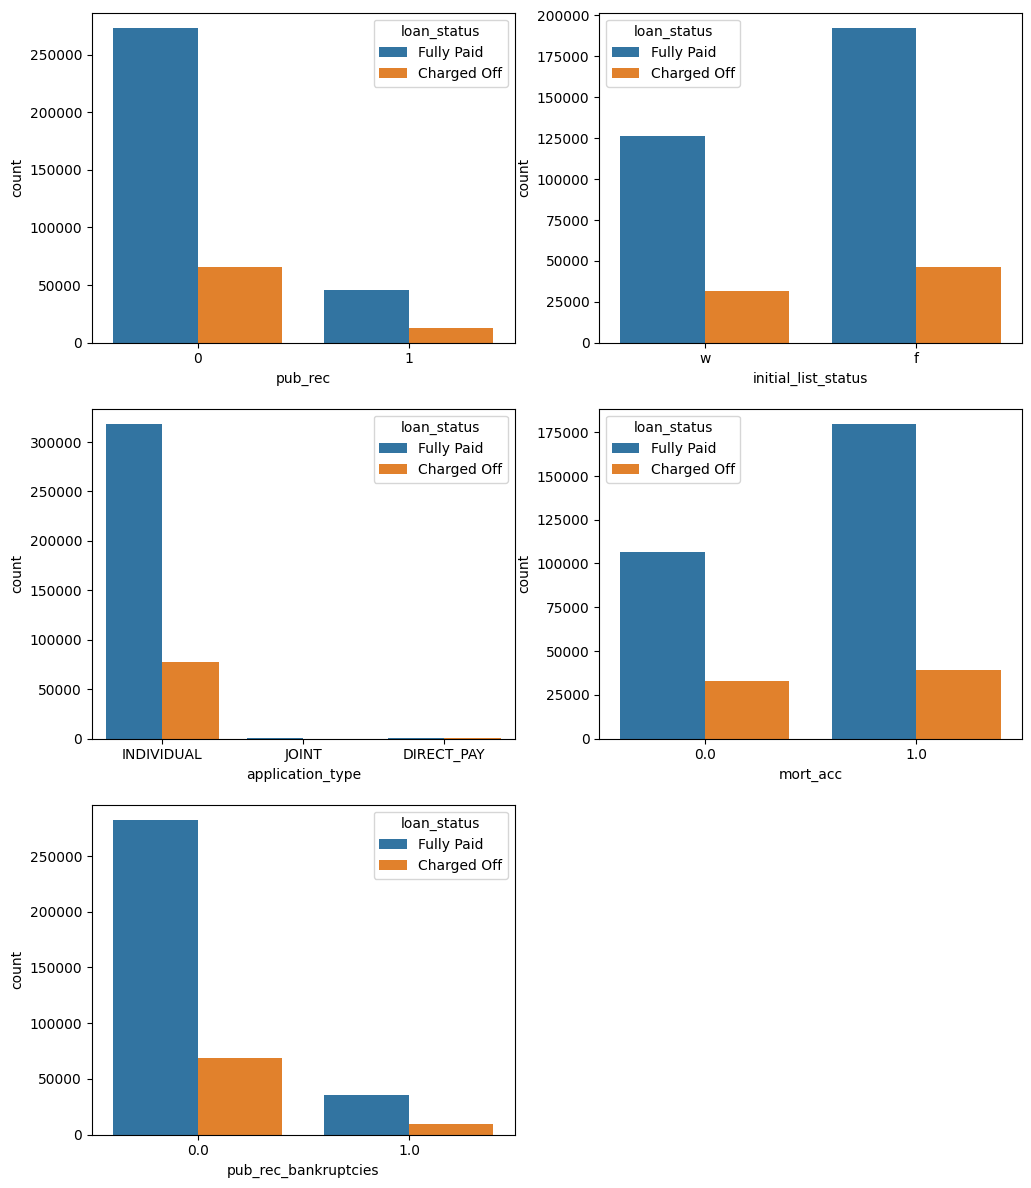

In [ ]:
plt.figure(figsize=(12, 30))

plt.subplot(6, 2, 1)
sns.countplot(x='pub_rec', data=data, hue='loan_status')

plt.subplot(6, 2, 2)
sns.countplot(x='initial_list_status', data=data, hue='loan_status')

plt.subplot(6, 2, 3)
sns.countplot(x='application_type', data=data, hue='loan_status')

plt.subplot(6, 2, 4)
sns.countplot(x='mort_acc', data=data, hue='loan_status')

plt.subplot(6, 2, 5)
sns.countplot(x='pub_rec_bankruptcies', data=data, hue='loan_status')

In [ ]:
data['loan_status'] = data.loan_status.map({'Fully Paid':1, 'Charged Off':0})


In [ ]:
import hvplot.pandas
import pandas as pd
data.corr(numeric_only=True)['loan_status'].drop('loan_status').sort_values().hvplot.barh(
    width=600, height=400,
    title="Correlation between Loan status and Numeric Features",
    ylabel='Correlation', xlabel='Numerical Features',
)


:Bars   [index]   (loan_status)

In [ ]:


c = data[['loan_amnt','int_rate','installment','annual_inc','dti','open_acc','pub_rec','revol_bal','revol_util','total_acc','mort_acc','pub_rec_bankruptcies']]

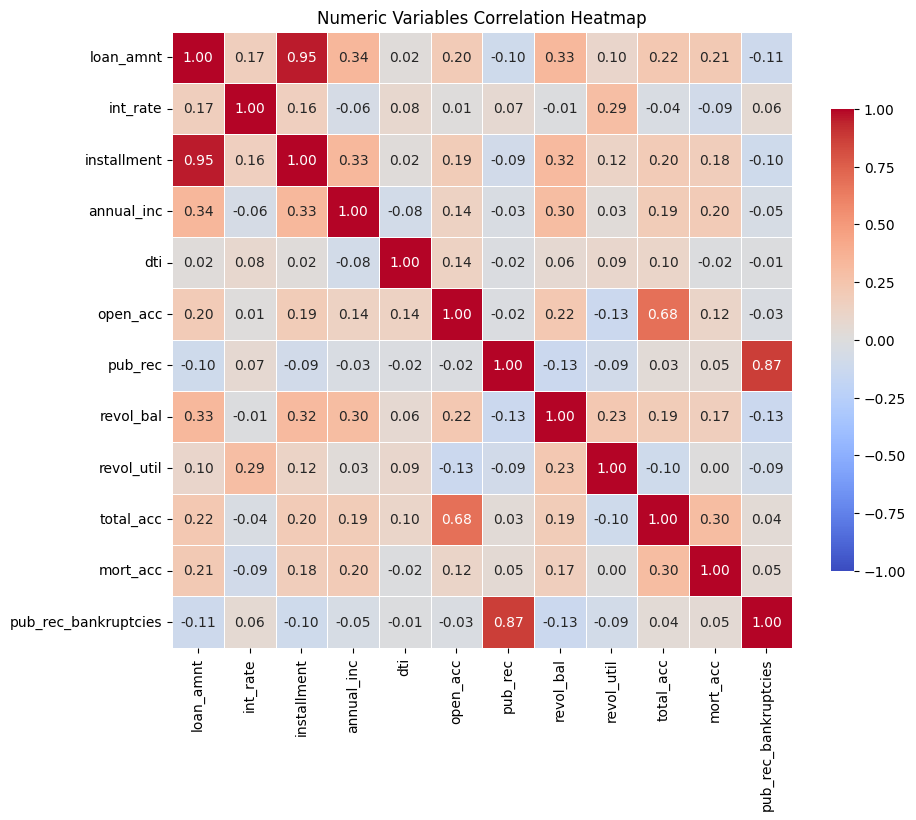

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = c.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f",
            linewidths=0.5, vmin=-1, vmax=1,
            cbar_kws={'shrink': .75})
plt.title('Numeric Variables Correlation Heatmap')
plt.show()

****


Data PreProcessing



In [ ]:

print(f"The Length of the data: {data.shape}")

The Length of the data: (396030, 27)


In [ ]:

for column in data.columns:
    if data[column].isna().sum() != 0:
        missing = data[column].isna().sum()
        portion = (missing / data.shape[0]) * 100
        print(f"'{column}': number of missing values '{missing}' ==> '{portion:.3f}%'")



'emp_title': number of missing values '22927' ==> '5.789%'
'emp_length': number of missing values '18301' ==> '4.621%'
'title': number of missing values '1756' ==> '0.443%'
'revol_util': number of missing values '276' ==> '0.070%'
'mort_acc': number of missing values '37795' ==> '9.543%'
'pub_rec_bankruptcies': number of missing values '535' ==> '0.135%'


In [ ]:
missing_data = []

for column in data.columns:

    missing = data[column].isna().sum()

    if missing != 0:
        portion = (missing / data.shape[0]) * 100
        missing_data.append({'Attribute': column, 'Missing Values': missing, 'Percentage (%)': f'{portion:.3f}'})

missing_df = pd.DataFrame(missing_data)


print(missing_df)

              Attribute  Missing Values Percentage (%)
0             emp_title           22927          5.789
1            emp_length           18301          4.621
2                 title            1756          0.443
3            revol_util             276          0.070
4              mort_acc           37795          9.543
5  pub_rec_bankruptcies             535          0.135


In [ ]:
missing_df['Percentage (%)'] = pd.to_numeric(missing_df['Percentage (%)'])


average_percentage = missing_df['Percentage (%)'].mean()
average_percentage

3.4335000000000004

emp_title

In [ ]:
data.emp_title.nunique()

173105

In [ ]:
data.drop('emp_title', axis=1, inplace=True)

emp_length

In [ ]:
data.emp_length.unique()

array(['10+ years', '4 years', '< 1 year', '6 years', '9 years',
       '2 years', '3 years', '8 years', '7 years', '5 years', '1 year',
       nan], dtype=object)

In [ ]:
unique_values = data.emp_length.unique()

padding_length = 16 - len(unique_values) if len(unique_values) < 16 else 0
padded_values = list(unique_values) + [None] * padding_length


table = pd.DataFrame([padded_values[:8], padded_values[8:16]])


print(table)

           0        1         2        3        4        5        6        7
0  10+ years  4 years  < 1 year  6 years  9 years  2 years  3 years  8 years
1    7 years  5 years    1 year      NaN     None     None     None     None


In [ ]:
for year in data.emp_length.unique():
    print(f"{year} years in this position:")
    print(f"{data[data.emp_length == year].loan_status.value_counts(normalize=True)}")
    print('==========================================')

10+ years years in this position:
loan_status
1   0.82
0   0.18
Name: proportion, dtype: float64
4 years years in this position:
loan_status
1   0.81
0   0.19
Name: proportion, dtype: float64
< 1 year years in this position:
loan_status
1   0.79
0   0.21
Name: proportion, dtype: float64
6 years years in this position:
loan_status
1   0.81
0   0.19
Name: proportion, dtype: float64
9 years years in this position:
loan_status
1   0.80
0   0.20
Name: proportion, dtype: float64
2 years years in this position:
loan_status
1   0.81
0   0.19
Name: proportion, dtype: float64
3 years years in this position:
loan_status
1   0.80
0   0.20
Name: proportion, dtype: float64
8 years years in this position:
loan_status
1   0.80
0   0.20
Name: proportion, dtype: float64
7 years years in this position:
loan_status
1   0.81
0   0.19
Name: proportion, dtype: float64
5 years years in this position:
loan_status
1   0.81
0   0.19
Name: proportion, dtype: float64
1 year years in this position:
loan_status
1   

In [ ]:
data.drop('emp_length', axis=1, inplace=True)




title

In [ ]:
top_titles = data.title.value_counts().head()


top_titles_df = top_titles.reset_index()

top_titles_df.columns = ['Title', 'Count']


print(top_titles_df)

                     Title   Count
0       debt consolidation  168108
1  credit card refinancing   51781
2         home improvement   17117
3                    other   12993
4            consolidation    5583


In [ ]:
top_purpose = data.purpose.value_counts().head()

top_purpose_df = top_purpose.reset_index()


top_purpose_df.columns = ['purpose', 'Count']


print(top_purpose_df)

              purpose   Count
0  debt_consolidation  234507
1         credit_card   83019
2    home_improvement   24030
3               other   21185
4      major_purchase    8790


In [ ]:
data.drop('title', axis=1, inplace=True)

In [ ]:
data.mort_acc.value_counts()

,count
mort_acc,
1.00,218458
0.00,139777


In [ ]:
data.mort_acc.isna().sum()

37795

<ipython-input-78-c509b59b83e0>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mort_acc_corr.values, y=mort_acc_corr.index, palette='viridis')


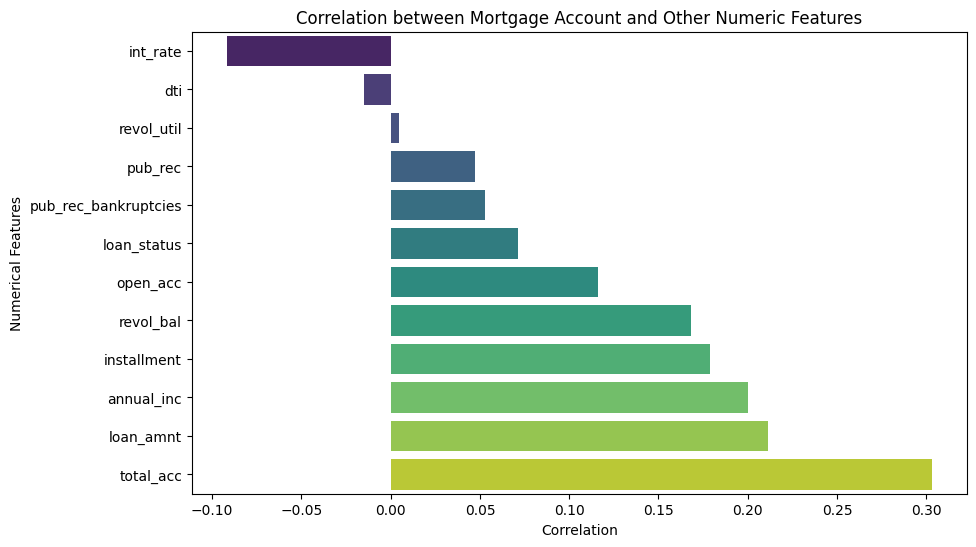

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


corr_matrix = data.corr(numeric_only=True)


mort_acc_corr = corr_matrix['mort_acc'].drop('mort_acc').sort_values()


plt.figure(figsize=(10, 6))
sns.barplot(x=mort_acc_corr.values, y=mort_acc_corr.index, palette='viridis')
plt.xlabel('Correlation')
plt.ylabel('Numerical Features')
plt.title('Correlation between Mortgage Account and Other Numeric Features')
plt.show()

In [ ]:
data.corr(numeric_only=True)['mort_acc'].drop('mort_acc').sort_values().hvplot.barh()

print(data.corr(numeric_only=True)['mort_acc'].drop('mort_acc').sort_values())

int_rate               -0.09
dti                    -0.02
revol_util              0.00
pub_rec                 0.05
pub_rec_bankruptcies    0.05
loan_status             0.07
open_acc                0.12
revol_bal               0.17
installment             0.18
annual_inc              0.20
loan_amnt               0.21
total_acc               0.30
Name: mort_acc, dtype: float64


In [ ]:
data.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.00,36 months,11.44,329.48,B,B4,RENT,117000.00,Not Verified,2015-01-01,1,vacation,26.24,1990-06-01,16.00,0,36369.00,41.80,25.00,w,INDIVIDUAL,0.00,0.00,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000.00,36 months,11.99,265.68,B,B5,MORTGAGE,65000.00,Not Verified,2015-01-01,1,debt_consolidation,22.05,2004-07-01,17.00,0,20131.00,53.30,27.00,f,INDIVIDUAL,1.00,0.00,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600.00,36 months,10.49,506.97,B,B3,RENT,43057.00,Source Verified,2015-01-01,1,credit_card,12.79,2007-08-01,13.00,0,11987.00,92.20,26.00,f,INDIVIDUAL,0.00,0.00,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,7200.00,36 months,6.49,220.65,A,A2,RENT,54000.00,Not Verified,2014-11-01,1,credit_card,2.60,2006-09-01,6.00,0,5472.00,21.50,13.00,f,INDIVIDUAL,0.00,0.00,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,24375.00,60 months,17.27,609.33,C,C5,MORTGAGE,55000.00,Verified,2013-04-01,0,credit_card,33.95,1999-03-01,13.00,0,24584.00,69.80,43.00,f,INDIVIDUAL,1.00,0.00,"679 Luna Roads\r\nGreggshire, VA 11650"


In [ ]:
num_data = data.select_dtypes(include=[np.number])

In [ ]:
num_data

,loan_amnt,int_rate,installment,annual_inc,loan_status,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies
0,10000.00,11.44,329.48,117000.00,1,26.24,16.00,0,36369.00,41.80,25.00,0.00,0.00
1,8000.00,11.99,265.68,65000.00,1,22.05,17.00,0,20131.00,53.30,27.00,1.00,0.00
2,15600.00,10.49,506.97,43057.00,1,12.79,13.00,0,11987.00,92.20,26.00,0.00,0.00
3,7200.00,6.49,220.65,54000.00,1,2.60,6.00,0,5472.00,21.50,13.00,0.00,0.00
4,24375.00,17.27,609.33,55000.00,0,33.95,13.00,0,24584.00,69.80,43.00,1.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
396025,10000.00,10.99,217.38,40000.00,1,15.63,6.00,0,1990.00,34.30,23.00,0.00,0.00
396026,21000.00,12.29,700.42,110000.00,1,21.45,6.00,0,43263.00,95.70,8.00,1.00,0.00
396027,5000.00,9.99,161.32,56500.00,1,17.56,15.00,0,32704.00,66.90,23.00,0.00,0.00
396028,21000.00,15.31,503.02,64000.00,1,15.88,9.00,0,15704.00,53.80,20.00,1.00,0.00


In [ ]:
total_acc_avg = num_data.groupby(by='total_acc').mean().mort_acc
total_acc_avg

,mort_acc
total_acc,
2.00,0.00
3.00,0.05
4.00,0.06
5.00,0.09
6.00,0.12
...,...
124.00,1.00
129.00,1.00
135.00,1.00


In [ ]:
def fill_mort_acc(total_acc, mort_acc):
    if np.isnan(mort_acc):
        return total_acc_avg[total_acc].round()
    else:
        return mort_acc

In [ ]:
data['mort_acc'] = data.apply(lambda x: fill_mort_acc(x['total_acc'], x['mort_acc']), axis=1)

revol_util & pub_rec_bankruptcies


In [ ]:
for column in data.columns:
    if data[column].isna().sum() != 0:
        missing = data[column].isna().sum()
        portion = (missing / data.shape[0]) * 100
        print(f"'{column}': number of missing values '{missing}' ==> '{portion:.3f}%'")

'revol_util': number of missing values '276' ==> '0.070%'
'pub_rec_bankruptcies': number of missing values '535' ==> '0.135%'


In [ ]:
data.dropna(inplace=True)

In [ ]:
data.shape

(395219, 24)

Categorical Variables

In [ ]:
print([column for column in data.columns if data[column].dtype == object])

['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status', 'purpose', 'initial_list_status', 'application_type', 'address']


term

In [ ]:
data.term.unique()

array([' 36 months', ' 60 months'], dtype=object)

In [ ]:
term_values = {' 36 months': 36, ' 60 months': 60}
data['term'] = data.term.map(term_values)

In [ ]:
data.term.unique()

array([36, 60])

grade & sub_grade


In [ ]:
data.drop('grade', axis=1, inplace=True)

In [ ]:
dummies = ['sub_grade', 'verification_status', 'purpose', 'initial_list_status',
           'application_type', 'home_ownership']
data = pd.get_dummies(data, columns=dummies, drop_first=True)

address


In [ ]:
data.address.head()

,address
0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,"679 Luna Roads\r\nGreggshire, VA 11650"


In [ ]:
data['zip_code'] = data.address.apply(lambda x: x[-5:])

In [ ]:
data.zip_code.value_counts()

,count
zip_code,
70466,56880
22690,56413
30723,56402
48052,55811
00813,45725
29597,45393
05113,45300
11650,11210
93700,11126


In [ ]:
data = pd.get_dummies(data, columns=['zip_code'], drop_first=True)

In [ ]:
data.drop('address', axis=1, inplace=True)

issue_d


In [ ]:
data.drop('issue_d', axis=1, inplace=True)

earliest_cr_line


In [ ]:
import datetime as dt

In [ ]:
data.earliest_cr_line

,earliest_cr_line
0,1990-06-01
1,2004-07-01
2,2007-08-01
3,2006-09-01
4,1999-03-01
...,...
396025,2004-11-01
396026,2006-02-01
396027,1997-03-01
396028,1990-11-01


In [ ]:

data['earliest_cr_line'] = pd.to_datetime(data['earliest_cr_line'], format='%b-%Y')

data['earliest_cr_line'] = data['earliest_cr_line'].dt.year

In [ ]:
data.earliest_cr_line.nunique()

65

In [ ]:
data.earliest_cr_line.value_counts()

,count
earliest_cr_line,
2000,29302
2001,29031
1999,26444
2002,25849
2003,23623
...,...
1951,3
1950,3
1953,2


In [ ]:
data.drop('earliest_cr_line', axis=1, inplace=True)

Check for duplicates

In [ ]:
print(f"Data shape: {data.shape}")

Data shape: (395219, 78)


In [ ]:
import pandas as pd


duplicates = data[data.duplicated()]


print("Duplicate Rows based on all columns:")
print(duplicates)


Duplicate Rows based on all columns:
Empty DataFrame
Columns: [loan_amnt, term, int_rate, installment, annual_inc, loan_status, dti, open_acc, pub_rec, revol_bal, revol_util, total_acc, mort_acc, pub_rec_bankruptcies, sub_grade_A2, sub_grade_A3, sub_grade_A4, sub_grade_A5, sub_grade_B1, sub_grade_B2, sub_grade_B3, sub_grade_B4, sub_grade_B5, sub_grade_C1, sub_grade_C2, sub_grade_C3, sub_grade_C4, sub_grade_C5, sub_grade_D1, sub_grade_D2, sub_grade_D3, sub_grade_D4, sub_grade_D5, sub_grade_E1, sub_grade_E2, sub_grade_E3, sub_grade_E4, sub_grade_E5, sub_grade_F1, sub_grade_F2, sub_grade_F3, sub_grade_F4, sub_grade_F5, sub_grade_G1, sub_grade_G2, sub_grade_G3, sub_grade_G4, sub_grade_G5, verification_status_Source Verified, verification_status_Verified, purpose_credit_card, purpose_debt_consolidation, purpose_educational, purpose_home_improvement, purpose_house, purpose_major_purchase, purpose_medical, purpose_moving, purpose_other, purpose_renewable_energy, purpose_small_business, purpos

Train Test Split

In [ ]:
w_p = data.loan_status.value_counts()[0] / data.shape[0]
w_n = data.loan_status.value_counts()[1] / data.shape[0]

print(w_p)
print(w_n)

0.19615200686201828
0.8038479931379817


## 📏 Normalizing the data

In [ ]:

train_original, test_original = train_test_split(data, test_size=0.33, random_state=42)


print(train_original.shape)
print(test_original.shape)

(264796, 78)
(130423, 78)


In [ ]:
X_train_original, y_train_original = train_original.drop('loan_status', axis=1), train_original.loan_status
X_test_original, y_test_original = test_original.drop('loan_status', axis=1), test_original.loan_status

In [ ]:
import pandas as pd
from imblearn.over_sampling import SMOTE

X = data.drop('loan_status', axis=1)
y = data['loan_status']


smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


balanced_data = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled, columns=['loan_status'])], axis=1)


train, test = train_test_split(balanced_data, test_size=0.33, random_state=42)
print(train.shape)
print(test.shape)


(425712, 78)
(209680, 78)


# Removing Outliers

In [ ]:
print(train_original[train_original['dti'] <= 50].shape)
train_original = train_original[train_original['annual_inc'] <= 250000]
train_original = train_original[train_original['dti'] <= 50]
train_original = train_original[train_original['open_acc'] <= 40]
train_original = train_original[train_original['total_acc'] <= 80]
train_original = train_original[train_original['revol_util'] <= 120]
train_original = train_original[train_original['revol_bal'] <= 250000]
print(train_original.shape)


(264776, 78)
(262143, 78)


In [ ]:
print(train[train['dti'] <= 50].shape)
train = train[train['annual_inc'] <= 250000]
train = train[train['dti'] <= 50]
train = train[train['open_acc'] <= 40]
train = train[train['total_acc'] <= 80]
train = train[train['revol_util'] <= 120]
train = train[train['revol_bal'] <= 250000]
print(train.shape)






(425679, 78)
(422036, 78)


In [ ]:
X_train, y_train = train.drop('loan_status', axis=1), train.loan_status
X_test, y_test = test.drop('loan_status', axis=1), test.loan_status

In [ ]:

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
scaler = MinMaxScaler()
X_train_original = scaler.fit_transform(X_train_original)
X_test_original = scaler.transform(X_test_original)


In [ ]:

original_counts = data['loan_status'].value_counts()

balanced_counts = balanced_data['loan_status'].value_counts()

percentage_difference = ((balanced_counts - original_counts) / original_counts) * 100


print("Original Data Loan Status Counts:")
print(original_counts)
print("\nBalanced Data Loan Status Counts:")
print(balanced_counts)
print("\nPercentage Difference:")
print(percentage_difference)


Original Data Loan Status Counts:
loan_status
1    317696
0     77523
Name: count, dtype: int64

Balanced Data Loan Status Counts:
loan_status
1    317696
0    317696
Name: count, dtype: int64

Percentage Difference:
loan_status
1     0.00
0   309.81
Name: count, dtype: float64


In [ ]:
disp = ConfusionMatrixDisplay.from_estimator(
    y_pred_original, X_test_original, y_test_original,
    cmap='Blues', values_format='d',
    display_labels=['Default', 'Fully-Paid']
)

disp = RocCurveDisplay.from_estimator(y_pred_original, X_test, y_test)


In [ ]:

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix

model_original = LogisticRegression(max_iter=1000, random_state=42)
model_original.fit(X_train_original, y_train_original)


y_pred_original = model_original.predict(X_test_original)


accuracy_original = accuracy_score(y_test_original, y_pred_original)
precision_original = precision_score(y_test_original, y_pred_original)
recall_original = recall_score(y_test_original, y_pred_original)
f1_original = f1_score(y_test_original, y_pred_original)
roc_auc_original = roc_auc_score(y_test_original, y_pred_original)


model_balanced = LogisticRegression(max_iter=1000, random_state=42)
model_balanced.fit(X_train, y_train)


y_pred_balanced = model_balanced.predict(X_test)


accuracy_balanced = accuracy_score(y_test, y_pred_balanced)
precision_balanced = precision_score(y_test, y_pred_balanced)
recall_balanced = recall_score(y_test, y_pred_balanced)
f1_balanced = f1_score(y_test, y_pred_balanced)
roc_auc_balanced = roc_auc_score(y_test, y_pred_balanced)


print("Original Data Metrics:")
print(f"  Accuracy: {accuracy_original:.4f}")
print(f"  Precision: {precision_original:.4f}")
print(f"  Recall: {recall_original:.4f}")
print(f"  F1-Score: {f1_original:.4f}")
print(f"  ROC AUC: {roc_auc_original:.4f}")
#print(classification_report(y_test_original, y_pred_original,digits = 4))
print("\nBalanced Data Metrics:")
print(f"  Accuracy: {accuracy_balanced:.4f}")
print(f"  Precision: {precision_balanced:.4f}")
print(f"  Recall: {recall_balanced:.4f}")
print(f"  F1-Score: {f1_balanced:.4f}")
print(f"  ROC AUC: {roc_auc_balanced:.4f}")
#print(classification_report(y_test, y_pred_balanced,digits = 4))




Original Data Metrics:
  Accuracy: 0.8890
  Precision: 0.8811
  Recall: 0.9965
  F1-Score: 0.9353
  ROC AUC: 0.7214

Balanced Data Metrics:
  Accuracy: 0.9294
  Precision: 0.8806
  Recall: 0.9932
  F1-Score: 0.9335
  ROC AUC: 0.9295


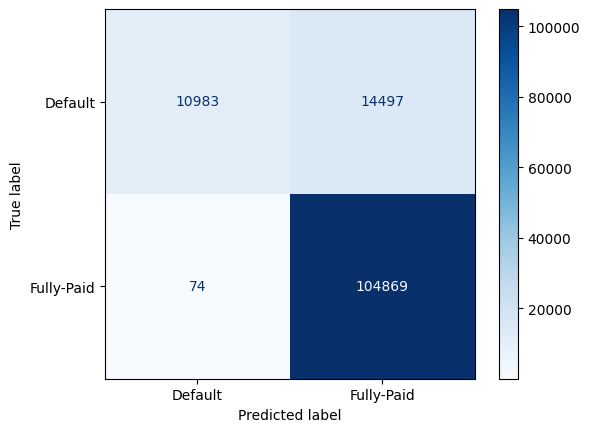

In [ ]:
disp = ConfusionMatrixDisplay.from_estimator(
    model_balanced, X_test_original, y_test_original,
    cmap='Blues', values_format='d',
    display_labels=['Default', 'Fully-Paid']
)

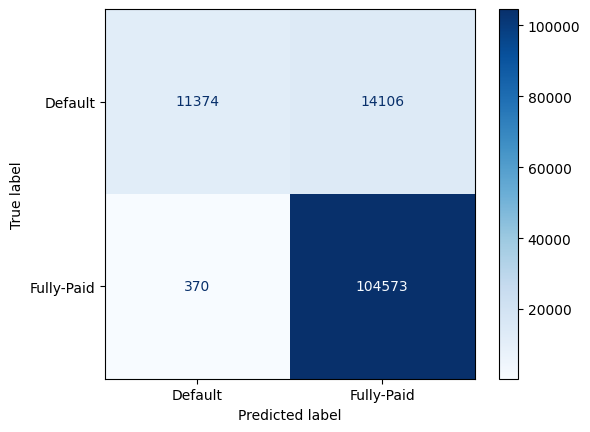

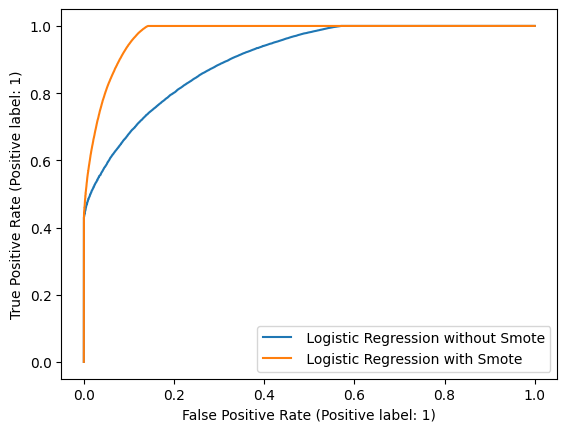

In [ ]:
disp = ConfusionMatrixDisplay.from_estimator(
    model_original, X_test_original, y_test_original,
    cmap='Blues', values_format='d',
    display_labels=['Default', 'Fully-Paid']
)

disp = RocCurveDisplay.from_estimator(model_original, X_test_original, y_test_original,label =" Logistic Regression without Smote")



RocCurveDisplay.from_estimator(model_balanced , X_test, y_test, ax=disp.ax_, label =" Logistic Regression with Smote")

In [ ]:

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


dt_original = DecisionTreeClassifier()
dt_original.fit(X_train_original, y_train_original)
y_pred_original = dt_original.predict(X_test_original)

dt_balanced = DecisionTreeClassifier()
dt_balanced.fit(X_train, y_train)
y_pred_balanced = dt_balanced.predict(X_test)

print("Evaluation on Original Data:")
print(classification_report(y_test_original, y_pred_original,digits = 4))
print(confusion_matrix(y_test_original, y_pred_original))

print("\nEvaluation on Balanced Data:")
print(classification_report(y_test, y_pred_balanced,digits = 4))
print(confusion_matrix(y_test, y_pred_balanced))


Evaluation on Original Data:
              precision    recall  f1-score   support

           0     0.5613    0.5924    0.5764     25480
           1     0.8997    0.8876    0.8936    104943

    accuracy                         0.8299    130423
   macro avg     0.7305    0.7400    0.7350    130423
weighted avg     0.8336    0.8299    0.8316    130423

[[15094 10386]
 [11799 93144]]

Evaluation on Balanced Data:
              precision    recall  f1-score   support

           0     0.8855    0.8965    0.8910    105002
           1     0.8949    0.8838    0.8893    104678

    accuracy                         0.8901    209680
   macro avg     0.8902    0.8901    0.8901    209680
weighted avg     0.8902    0.8901    0.8901    209680

[[94136 10866]
 [12168 92510]]


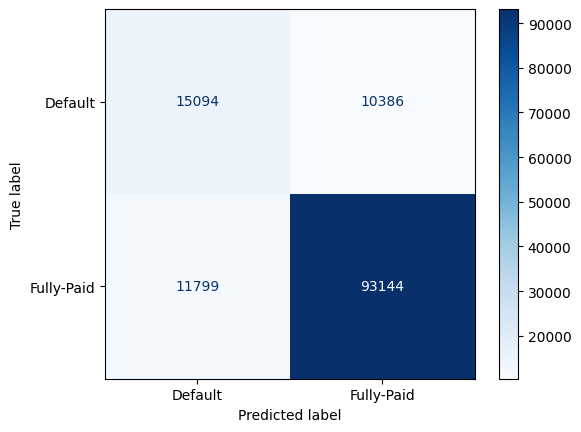

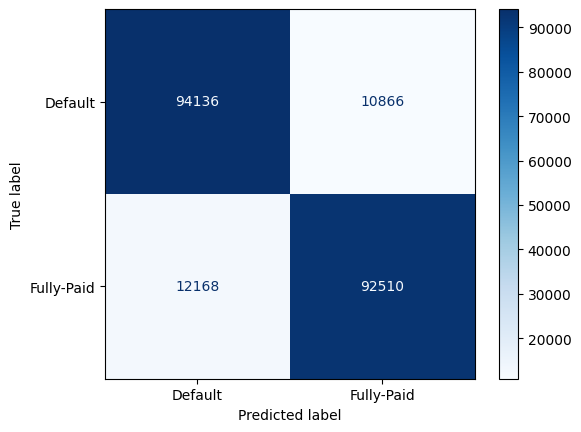

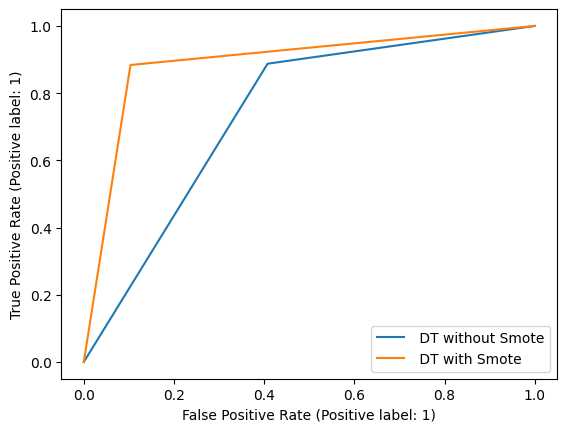

In [ ]:
disp = ConfusionMatrixDisplay.from_estimator(
    dt_original, X_test_original, y_test_original,
    cmap='Blues', values_format='d',
    display_labels=['Default', 'Fully-Paid']
)

disp = ConfusionMatrixDisplay.from_estimator(
    dt_balanced, X_test, y_test,
    cmap='Blues', values_format='d',
    display_labels=['Default', 'Fully-Paid']
)

disp = RocCurveDisplay.from_estimator(dt_original, X_test_original, y_test_original,label =" DT without Smote")



RocCurveDisplay.from_estimator(dt_balanced , X_test, y_test, ax=disp.ax_, label =" DT with Smote")

In [ ]:

model_original = Sequential()
model_original.add(Dense(78, activation='relu', input_shape=(X_train_original.shape[1],)))
model_original.add(Dropout(0.2))
model_original.add(Dense(39, activation='relu'))
model_original.add(Dropout(0.2))
model_original.add(Dense(1, activation='sigmoid'))

model_original.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', AUC()])

model_original.fit(X_train_original, y_train_original, epochs=25, batch_size=256, validation_data=(X_test_original, y_test_original))

y_pred_original = (model_original.predict(X_test_original) > 0.5).astype("int32")

print("\nEvaluation on Original Data:")
print(classification_report(y_test_original, y_pred_original,digits = 4))
print(confusion_matrix(y_test_original, y_pred_original))
accuracy_original = accuracy_score(y_test_original, y_pred_original)
precision_original = precision_score(y_test_original, y_pred_original)
recall_original = recall_score(y_test_original, y_pred_original)
f1_original = f1_score(y_test_original, y_pred_original)
roc_auc_original = roc_auc_score(y_test_original, y_pred_original)
print("Original Data Metrics:")
print(f"  Accuracy: {accuracy_original:.4f}")
print(f"  Precision: {precision_original:.4f}")
print(f"  Recall: {recall_original:.4f}")
print(f"  F1-Score: {f1_original:.4f}")
print(f"  ROC AUC: {roc_auc_original:.4f}")

model_balanced = Sequential()
model_balanced.add(Dense(78, activation='relu', input_shape=(X_train.shape[1],)))
model_balanced.add(Dropout(0.2))
model_balanced.add(Dense(39, activation='relu'))
model_balanced.add(Dropout(0.2))
model_balanced.add(Dense(1, activation='sigmoid'))

model_balanced.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', AUC()])

model_balanced.fit(X_train, y_train, epochs=25, batch_size=256, validation_data=(X_test, y_test))

y_pred_balanced = (model_balanced.predict(X_test) > 0.5).astype("int32")

print("\nEvaluation on Balanced Data:")
print(classification_report(y_test, y_pred_balanced,digits = 4))
print(confusion_matrix(y_test, y_pred_balanced))
accuracy_balanced = accuracy_score(y_test, y_pred_balanced)
precision_balanced = precision_score(y_test, y_pred_balanced)
recall_balanced = recall_score(y_test, y_pred_balanced)
f1_balanced = f1_score(y_test, y_pred_balanced)
roc_auc_balanced = roc_auc_score(y_test, y_pred_balanced)
print("\nBalanced Data Metrics:")
print(f"  Accuracy: {accuracy_balanced:.4f}")
print(f"  Precision: {precision_balanced:.4f}")
print(f"  Recall: {recall_balanced:.4f}")
print(f"  F1-Score: {f1_balanced:.4f}")
print(f"  ROC AUC: {roc_auc_balanced:.4f}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.8446 - auc: 0.7957 - loss: 0.3684 - val_accuracy: 0.8886 - val_auc: 0.8989 - val_loss: 0.2642
Epoch 2/25
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.8882 - auc: 0.8950 - loss: 0.2670 - val_accuracy: 0.8885 - val_auc: 0.9011 - val_loss: 0.2609
Epoch 3/25
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8880 - auc: 0.8980 - loss: 0.2641 - val_accuracy: 0.8885 - val_auc: 0.9018 - val_loss: 0.2601
Epoch 4/25
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.8879 - auc: 0.8993 - loss: 0.2631 - val_accuracy: 0.8885 - val_auc: 0.9027 - val_loss: 0.2593
Epoch 5/25
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.8879 - auc: 0.9007 - loss: 0.2621 - val_accuracy: 0.8885 - val_auc: 0.9026 - val_loss: 0.2595
Epoch 6/25
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.8892 - auc: 0.9020 - loss: 0.2594 - val_accuracy: 0.8888 - val_auc: 0.9030 - val_loss: 0.2589
Epoch 7/25
1035/1035

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
1649/1649 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8820 - auc_1: 0.9474 - loss: 0.2618 - val_accuracy: 0.9289 - val_auc_1: 0.9761 - val_loss: 0.1659
Epoch 2/25
1649/1649 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9291 - auc_1: 0.9752 - loss: 0.1672 - val_accuracy: 0.9287 - val_auc_1: 0.9763 - val_loss: 0.1642
Epoch 3/25
1649/1649 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9300 - auc_1: 0.9762 - loss: 0.1629 - val_accuracy: 0.9291 - val_auc_1: 0.9765 - val_loss: 0.1635
Epoch 4/25
1649/1649 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9309 - auc_1: 0.9764 - loss: 0.1616 - val_accuracy: 0.9293 - val_auc_1: 0.9765 - val_loss: 0.1626
Epoch 5/25
1649/1649 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9312 - auc_1: 0.9769 - loss: 0.1601 - val_accuracy: 0.9296 - val_auc_1: 0.9767 - val_loss: 0.1623
Epoch 6/25
1649/1649 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9301 - auc_1: 0.9767 - loss: 0.1613 - val_accuracy: 0.9298 - val_auc_1: 0.9765 - val_loss: 0.1621
E

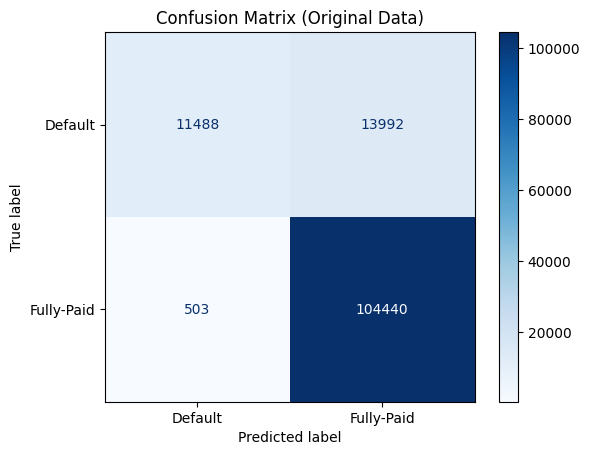

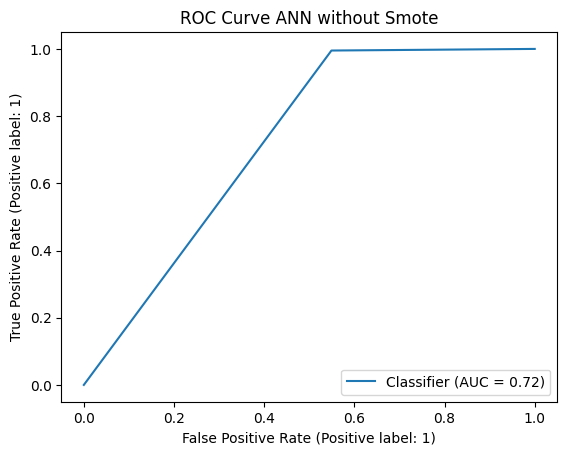

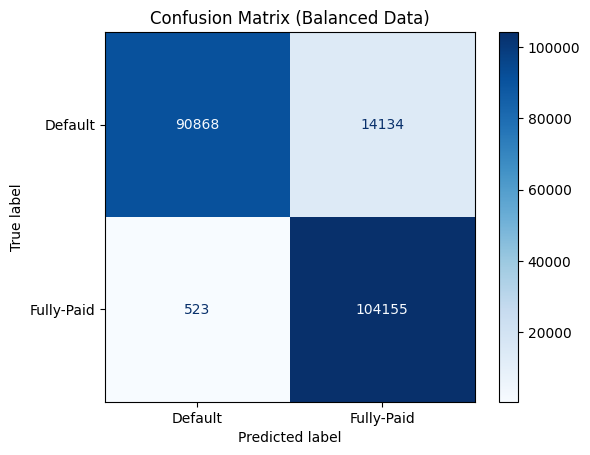

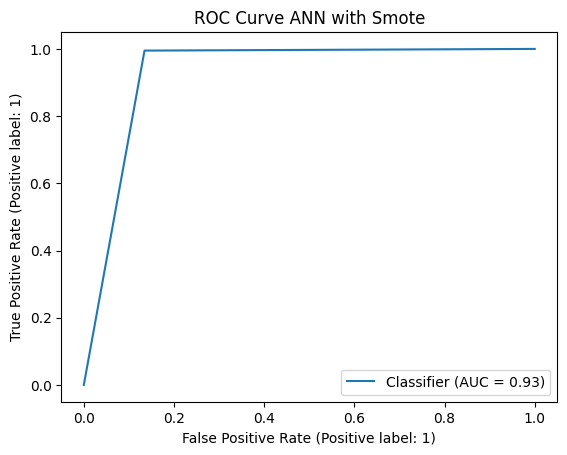

In [ ]:
# prompt: print confusion matrix and roc curve for above code

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

# Assuming y_pred_original and y_test_original are your predictions and true labels for the original data
cm_original = confusion_matrix(y_test_original, y_pred_original)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_original, display_labels=['Default', 'Fully-Paid'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix (Original Data)')
plt.show()

disp = RocCurveDisplay.from_predictions(y_test_original, y_pred_original)

plt.title('ROC Curve ANN without Smote')
plt.show()

# Assuming y_pred_balanced and y_test are your predictions and true labels for the balanced data
cm_balanced = confusion_matrix(y_test, y_pred_balanced)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_balanced, display_labels=['Default', 'Fully-Paid'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix (Balanced Data)')
plt.show()

disp = RocCurveDisplay.from_predictions(y_test, y_pred_balanced)

plt.title('ROC Curve ANN with Smote')
plt.show()


In [ ]:
xgb_original = XGBClassifier()
xgb_original.fit(X_train_original, y_train_original)
y_pred_original = xgb_original.predict(X_test_original)

print("\nEvaluation on Original Data:")
print(classification_report(y_test_original, y_pred_original,digits = 4))
print(confusion_matrix(y_test_original, y_pred_original))

# For Balanced Data
X_train, X_test, y_train, y_test = train_test_split(
    balanced_data.drop('loan_status', axis=1), balanced_data['loan_status'], test_size=0.33, random_state=42
)

xgb_balanced = XGBClassifier()
xgb_balanced.fit(X_train, y_train)
y_pred_balanced = xgb_balanced.predict(X_test)

print("\nEvaluation on Balanced Data:")
print(classification_report(y_test, y_pred_balanced,digits = 4))
print(confusion_matrix(y_test, y_pred_balanced))



Evaluation on Original Data:
              precision    recall  f1-score   support

           0     0.9094    0.4813    0.6295     25480
           1     0.8870    0.9884    0.9349    104943

    accuracy                         0.8893    130423
   macro avg     0.8982    0.7348    0.7822    130423
weighted avg     0.8914    0.8893    0.8753    130423

[[ 12264  13216]
 [  1222 103721]]

Evaluation on Balanced Data:
              precision    recall  f1-score   support

           0     0.9877    0.8698    0.9250    105002
           1     0.8834    0.9891    0.9333    104678

    accuracy                         0.9294    209680
   macro avg     0.9355    0.9295    0.9292    209680
weighted avg     0.9356    0.9294    0.9291    209680

[[ 91335  13667]
 [  1138 103540]]


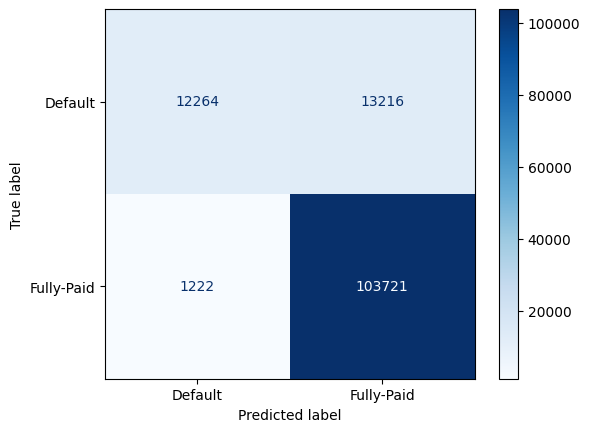

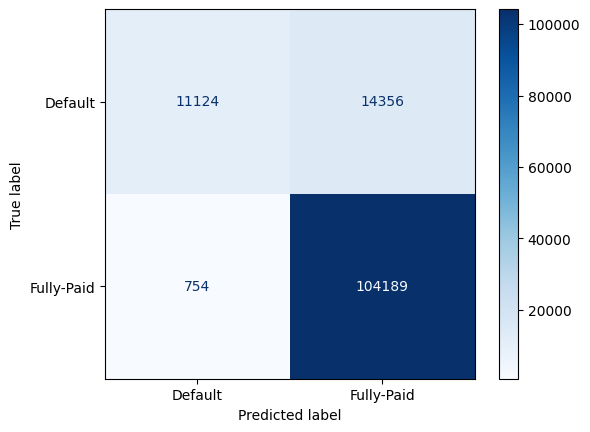

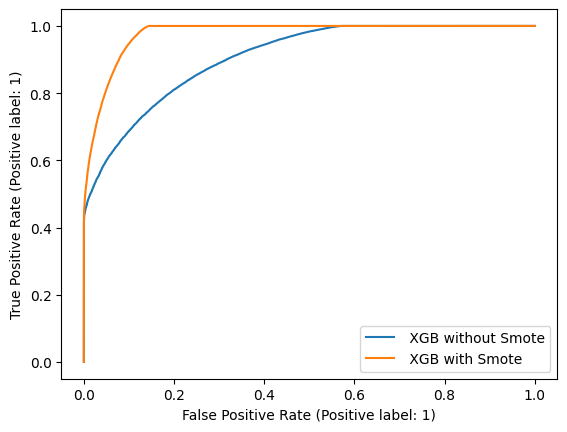

In [ ]:
disp = ConfusionMatrixDisplay.from_estimator(
    xgb_original, X_test_original, y_test_original,
    cmap='Blues', values_format='d',
    display_labels=['Default', 'Fully-Paid']
)
disp = ConfusionMatrixDisplay.from_estimator(
    xgb_balanced, X_test_original, y_test_original,
    cmap='Blues', values_format='d',
    display_labels=['Default', 'Fully-Paid']
)
disp = RocCurveDisplay.from_estimator(xgb_original, X_test_original, y_test_original,label =" XGB without Smote")



RocCurveDisplay.from_estimator(xgb_balanced , X_test, y_test, ax=disp.ax_, label =" XGB with Smote")

In [ ]:


rf_original = RandomForestClassifier()
rf_original.fit(X_train_original, y_train_original)
y_pred_original = rf_original.predict(X_test_original)

print("\nEvaluation on Original Data:")
print(classification_report(y_test_original, y_pred_original,digits = 4))
print(confusion_matrix(y_test_original, y_pred_original))


X_train, X_test, y_train, y_test = train_test_split(
    balanced_data.drop('loan_status', axis=1), balanced_data['loan_status'], test_size=0.33, random_state=42
)

rf_balanced = RandomForestClassifier()
rf_balanced.fit(X_train, y_train)
y_pred_balanced = rf_balanced.predict(X_test)

print("\nEvaluation on Balanced Data:")
print(classification_report(y_test, y_pred_balanced,digits = 4))
print(confusion_matrix(y_test, y_pred_balanced))



Evaluation on Original Data:
              precision    recall  f1-score   support

           0     0.9500    0.4555    0.6158     25480
           1     0.8826    0.9942    0.9351    104943

    accuracy                         0.8889    130423
   macro avg     0.9163    0.7249    0.7754    130423
weighted avg     0.8958    0.8889    0.8727    130423

[[ 11607  13873]
 [   611 104332]]

Evaluation on Balanced Data:
              precision    recall  f1-score   support

           0     0.9856    0.8721    0.9254    105002
           1     0.8850    0.9872    0.9333    104678

    accuracy                         0.9296    209680
   macro avg     0.9353    0.9297    0.9294    209680
weighted avg     0.9354    0.9296    0.9293    209680

[[ 91572  13430]
 [  1337 103341]]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


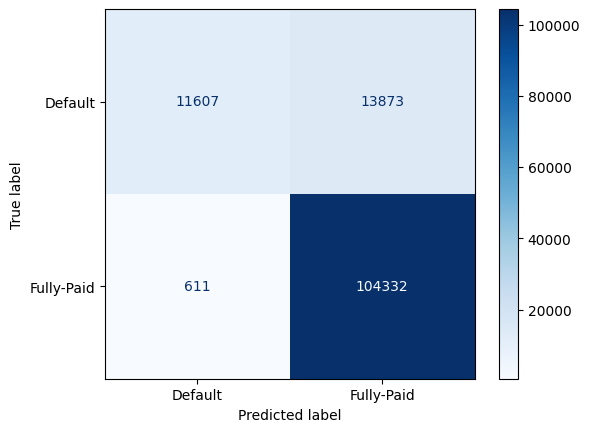

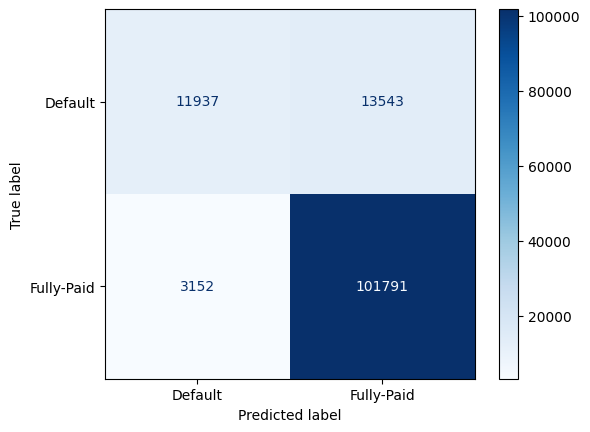

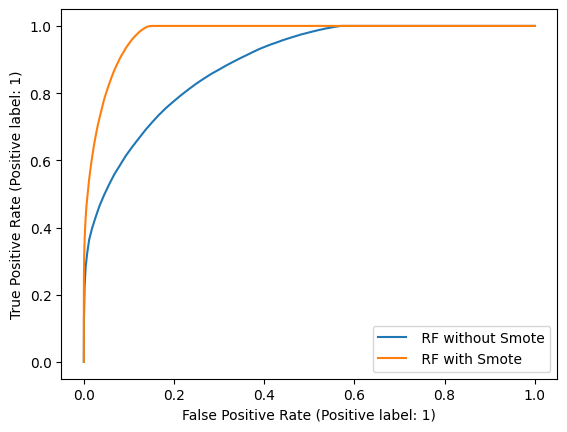

In [ ]:
disp = ConfusionMatrixDisplay.from_estimator(
    rf_original, X_test_original, y_test_original,
    cmap='Blues', values_format='d',
    display_labels=['Default', 'Fully-Paid']
)
disp = ConfusionMatrixDisplay.from_estimator(
    rf_balanced, X_test_original, y_test_original,
    cmap='Blues', values_format='d',
    display_labels=['Default', 'Fully-Paid']
)
disp = RocCurveDisplay.from_estimator(rf_original, X_test_original, y_test_original,label =" RF without Smote")



RocCurveDisplay.from_estimator(rf_balanced , X_test, y_test, ax=disp.ax_, label =" RF with Smote")

# 🤖 Models Building

In [ ]:
def print_score(true, pred, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")

    elif train==False:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")

In [ ]:
X_train = np.array(X_train).astype(np.float32)
X_test = np.array(X_test).astype(np.float32)
y_train = np.array(y_train).astype(np.float32)
y_test = np.array(y_test).astype(np.float32)

# ✔️ Artificial Neural Networks (ANNs)

In [ ]:
def evaluate_nn(true, pred, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")

    elif train==False:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")

def plot_learning_evolution(r):
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.plot(r.history['loss'], label='Loss')
    plt.plot(r.history['val_loss'], label='val_Loss')
    plt.title('Loss evolution during trainig')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(r.history['AUC'], label='AUC')
    plt.plot(r.history['val_AUC'], label='val_AUC')
    plt.title('AUC score evolution during trainig')
    plt.legend();

def nn_model(num_columns, num_labels, hidden_units, dropout_rates, learning_rate):
    inp = tf.keras.layers.Input(shape=(num_columns, ))
    x = BatchNormalization()(inp)
    x = Dropout(dropout_rates[0])(x)
    for i in range(len(hidden_units)):
        x = Dense(hidden_units[i], activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(dropout_rates[i + 1])(x)
    x = Dense(num_labels, activation='sigmoid')(x)

    model = Model(inputs=inp, outputs=x)
    model.compile(optimizer=Adam(learning_rate), loss='binary_crossentropy', metrics=[AUC(name='AUC')])
    return model

In [ ]:
num_columns = X_train.shape[1]
num_labels = 1
hidden_units = [150, 150, 150]
dropout_rates = [0.1, 0, 0.1, 0]
learning_rate = 1e-3


model = nn_model(
    num_columns=num_columns,
    num_labels=num_labels,
    hidden_units=hidden_units,
    dropout_rates=dropout_rates,
    learning_rate=learning_rate
)
r = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32
)

Epoch 1/20
13304/13304 ━━━━━━━━━━━━━━━━━━━━ 70s 5ms/step - AUC: 0.9517 - loss: 0.2556 - val_AUC: 0.9735 - val_loss: 0.1751
Epoch 2/20
13304/13304 ━━━━━━━━━━━━━━━━━━━━ 81s 5ms/step - AUC: 0.9648 - loss: 0.2048 - val_AUC: 0.9745 - val_loss: 0.1765
Epoch 3/20
13304/13304 ━━━━━━━━━━━━━━━━━━━━ 74s 6ms/step - AUC: 0.9666 - loss: 0.1967 - val_AUC: 0.9749 - val_loss: 0.1786
Epoch 4/20
13304/13304 ━━━━━━━━━━━━━━━━━━━━ 70s 5ms/step - AUC: 0.9670 - loss: 0.1949 - val_AUC: 0.9747 - val_loss: 0.1842
Epoch 5/20
13304/13304 ━━━━━━━━━━━━━━━━━━━━ 81s 5ms/step - AUC: 0.9682 - loss: 0.1912 - val_AUC: 0.9729 - val_loss: 0.1886
Epoch 6/20
13304/13304 ━━━━━━━━━━━━━━━━━━━━ 63s 5ms/step - AUC: 0.9680 - loss: 0.1916 - val_AUC: 0.9716 - val_loss: 0.3072
Epoch 7/20
13304/13304 ━━━━━━━━━━━━━━━━━━━━ 64s 5ms/step - AUC: 0.9684 - loss: 0.1904 - val_AUC: 0.9732 - val_loss: 0.1922
Epoch 8/20
13304/13304 ━━━━━━━━━━━━━━━━━━━━ 74s 6ms/step - AUC: 0.9683 - loss: 0.1901 - val_AUC: 0.9739 - val_loss: 0.2621
Epoch 9/20
13304

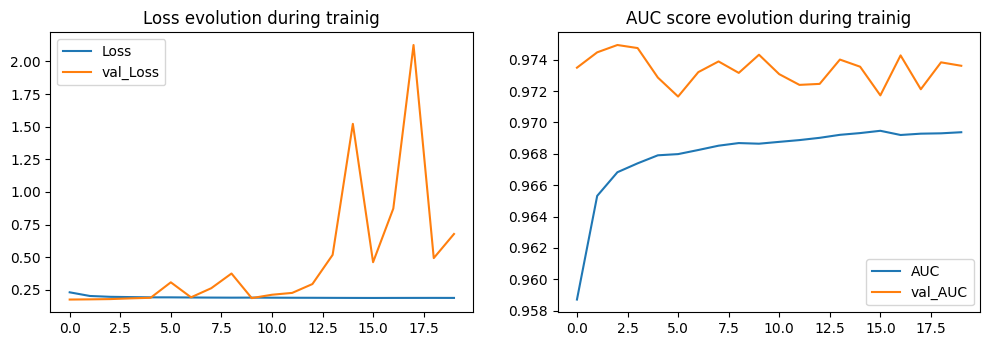

In [ ]:
plot_learning_evolution(r)

In [ ]:
y_train_pred = model.predict(X_train)
evaluate_nn(y_train, y_train_pred.round(), train=True)

13304/13304 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step
Train Result:
Accuracy Score: 92.70%
_______________________________________________
CLASSIFICATION REPORT:
                0.0       1.0  accuracy  macro avg  weighted avg
precision      0.98      0.88      0.93       0.93          0.93
recall         0.87      0.98      0.93       0.93          0.93
f1-score       0.92      0.93      0.93       0.93          0.93
support   212694.00 213018.00      0.93  425712.00     425712.00
_______________________________________________
Confusion Matrix: 
 [[185084  27610]
 [  3457 209561]]



In [ ]:
y_test_pred = model.predict(X_test)
evaluate_nn(y_test, y_test_pred.round(), train=False)

6553/6553 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
Test Result:
Accuracy Score: 92.64%
_______________________________________________
CLASSIFICATION REPORT:
                0.0       1.0  accuracy  macro avg  weighted avg
precision      0.98      0.88      0.93       0.93          0.93
recall         0.87      0.98      0.93       0.93          0.93
f1-score       0.92      0.93      0.93       0.93          0.93
support   105002.00 104678.00      0.93  209680.00     209680.00
_______________________________________________
Confusion Matrix: 
 [[ 91206  13796]
 [  1633 103045]]



In [ ]:
scores_dict = {
    'ANNs': {
        'Train': roc_auc_score(y_train, model.predict(X_train)),
        'Test': roc_auc_score(y_test, model.predict(X_test)),
    },
}
scores_dict

13304/13304 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step
6553/6553 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step


{'ANNs': {'Train': 0.9737944263583113, 'Test': 0.9732525686240747}}

In [ ]:
scores_dict

{'ANNs': {'Train': 0.9737944263583113, 'Test': 0.9732525686240747}}

Epoch 1/20
8275/8275 ━━━━━━━━━━━━━━━━━━━━ 57s 6ms/step - AUC: 0.8413 - loss: 0.3309 - val_AUC: 0.9007 - val_loss: 0.2658
Epoch 2/20
8275/8275 ━━━━━━━━━━━━━━━━━━━━ 72s 5ms/step - AUC: 0.8741 - loss: 0.2939 - val_AUC: 0.9050 - val_loss: 0.2604
Epoch 3/20
8275/8275 ━━━━━━━━━━━━━━━━━━━━ 83s 5ms/step - AUC: 0.8804 - loss: 0.2872 - val_AUC: 0.9052 - val_loss: 0.2616
Epoch 4/20
8275/8275 ━━━━━━━━━━━━━━━━━━━━ 89s 6ms/step - AUC: 0.8843 - loss: 0.2836 - val_AUC: 0.9057 - val_loss: 0.2613
Epoch 5/20
8275/8275 ━━━━━━━━━━━━━━━━━━━━ 73s 5ms/step - AUC: 0.8862 - loss: 0.2818 - val_AUC: 0.9063 - val_loss: 0.2607
Epoch 6/20
8275/8275 ━━━━━━━━━━━━━━━━━━━━ 51s 6ms/step - AUC: 0.8871 - loss: 0.2805 - val_AUC: 0.9064 - val_loss: 0.2595
Epoch 7/20
8275/8275 ━━━━━━━━━━━━━━━━━━━━ 74s 5ms/step - AUC: 0.8889 - loss: 0.2785 - val_AUC: 0.9061 - val_loss: 0.2589
Epoch 8/20
8275/8275 ━━━━━━━━━━━━━━━━━━━━ 46s 6ms/step - AUC: 0.8905 - loss: 0.2784 - val_AUC: 0.9070 - val_loss: 0.2566
Epoch 9/20
8275/8275 ━━━━━━━━━━━

{'ANNs': {'Train': 0.9068354581222989, 'Test': 0.9052892269797773}}

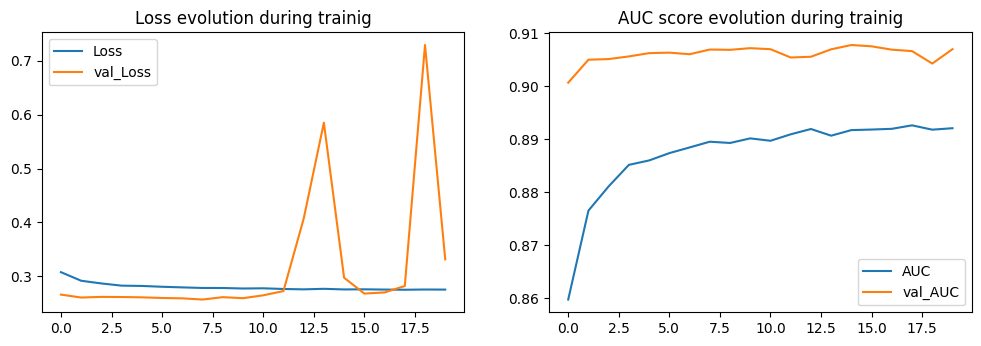

In [ ]:
num_columns = X_train_original.shape[1]
num_labels = 1
hidden_units = [150, 150, 150]
dropout_rates = [0.1, 0, 0.1, 0]
learning_rate = 1e-3


model = nn_model(
    num_columns=num_columns,
    num_labels=num_labels,
    hidden_units=hidden_units,
    dropout_rates=dropout_rates,
    learning_rate=learning_rate
)
r = model.fit(
    X_train_original, y_train_original,
    validation_data=(X_train_original, y_train_original),
    epochs=20,
    batch_size=32
)

plot_learning_evolution(r)
y_train_pred = model.predict(X_train_original)
evaluate_nn(y_train_original, y_train_pred.round(), train=True)
y_test_pred = model.predict(X_test_original)
evaluate_nn(y_test_original, y_test_pred.round(), train=False)
scores_dict = {
    'ANNs': {
        'Train': roc_auc_score(y_train_original, model.predict(X_train_original)),
        'Test': roc_auc_score(y_test_original, model.predict(X_test_original)),
    },
}
scores_dict

# ✔️ XGBoost Classifier

In [ ]:
# param_grid = dict(
#     n_estimators=stats.randint(10, 500),
#     max_depth=stats.randint(1, 10),
#     learning_rate=stats.uniform(0, 1)
# )

xgb_clf = XGBClassifier(use_label_encoder=False)
# xgb_cv = RandomizedSearchCV(
#     xgb_clf, param_grid, cv=3, n_iter=60,
#     scoring='roc_auc', n_jobs=-1, verbose=1
# )
# xgb_cv.fit(X_train, y_train)

# best_params = xgb_cv.best_params_
# best_params['tree_method'] = 'gpu_hist'
# # best_params = {'n_estimators': 50, 'tree_method': 'gpu_hist'}
# print(f"Best Parameters: {best_params}")

# xgb_clf = XGBClassifier(**best_params)
xgb_clf.fit(X_train, y_train)

y_train_pred = xgb_clf.predict(X_train)
y_test_pred = xgb_clf.predict(X_test)

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:09:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Train Result:
Accuracy Score: 93.33%
_______________________________________________
CLASSIFICATION REPORT:
                0.0       1.0  accuracy  macro avg  weighted avg
precision      0.99      0.89      0.93       0.94          0.94
recall         0.87      0.99      0.93       0.93          0.93
f1-score       0.93      0.94      0.93       0.93          0.93
support   212694.00 213018.00      0.93  425712.00     425712.00
_______________________________________________
Confusion Matrix: 
 [[186055  26639]
 [  1745 211273]]

Test Result:
Accuracy Score: 92.94%
_______________________________________________
CLASSIFICATION REPORT:
                0.0       1.0  accuracy  macro avg  weighted avg
precision      0.99      0.88      0.93       0.94          0.94
recall         0.87      0.99      0.93       0.93          0.93
f1-score       0.93      0.93      0.93       0.93          0.93
support   105002.00 104678.00      0.93  209680.00     209680.00
_______________________________

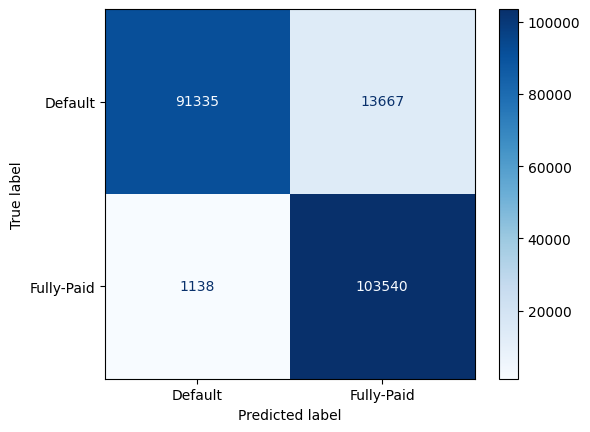

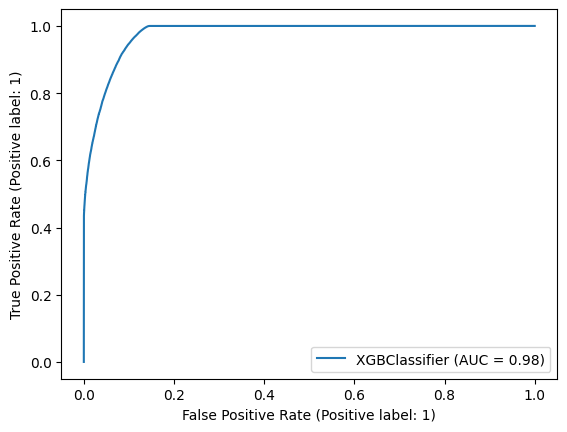

In [ ]:
disp = ConfusionMatrixDisplay.from_estimator(
    xgb_clf, X_test, y_test,
    cmap='Blues', values_format='d',
    display_labels=['Default', 'Fully-Paid']
)

disp = RocCurveDisplay.from_estimator(xgb_clf, X_test, y_test)

In [ ]:
scores_dict['XGBoost'] = {
        'Train': roc_auc_score(y_train, xgb_clf.predict(X_train)),
        'Test': roc_auc_score(y_test, xgb_clf.predict(X_test)),
    }

# ✔️ Random Forest Classifier

In [ ]:
# param_grid = dict(
#     n_estimators=stats.randint(100, 1500),
#     max_depth=stats.randint(10, 100),
#     min_samples_split=stats.randint(1, 10),
#     min_samples_leaf=stats.randint(1, 10),
# )

rf_clf = RandomForestClassifier(n_estimators=100)
# rf_cv = RandomizedSearchCV(
#     rf_clf, param_grid, cv=3, n_iter=60,
#     scoring='roc_auc', n_jobs=-1, verbose=1
# )
# rf_cv.fit(X_train, y_train)
# best_params = rf_cv.best_params_
# print(f"Best Parameters: {best_params}")
# rf_clf = RandomForestClassifier(**best_params)
rf_clf.fit(X_train, y_train)

y_train_pred = rf_clf.predict(X_train)
y_test_pred = rf_clf.predict(X_test)

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)

Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
                0.0       1.0  accuracy  macro avg  weighted avg
precision      1.00      1.00      1.00       1.00          1.00
recall         1.00      1.00      1.00       1.00          1.00
f1-score       1.00      1.00      1.00       1.00          1.00
support   212694.00 213018.00      1.00  425712.00     425712.00
_______________________________________________
Confusion Matrix: 
 [[212692      2]
 [     0 213018]]

Test Result:
Accuracy Score: 92.98%
_______________________________________________
CLASSIFICATION REPORT:
                0.0       1.0  accuracy  macro avg  weighted avg
precision      0.99      0.88      0.93       0.94          0.94
recall         0.87      0.99      0.93       0.93          0.93
f1-score       0.93      0.93      0.93       0.93          0.93
support   105002.00 104678.00      0.93  209680.00     209680.00
______________________________

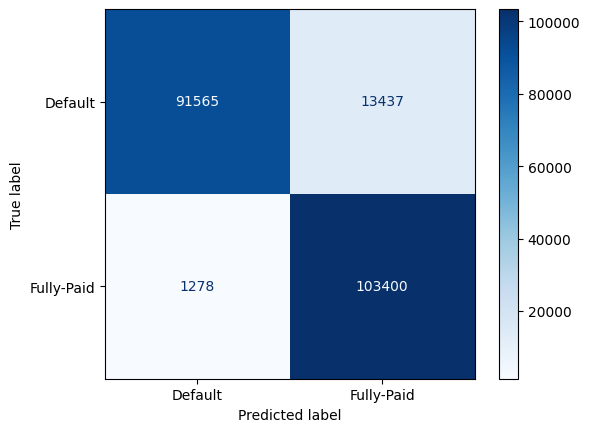

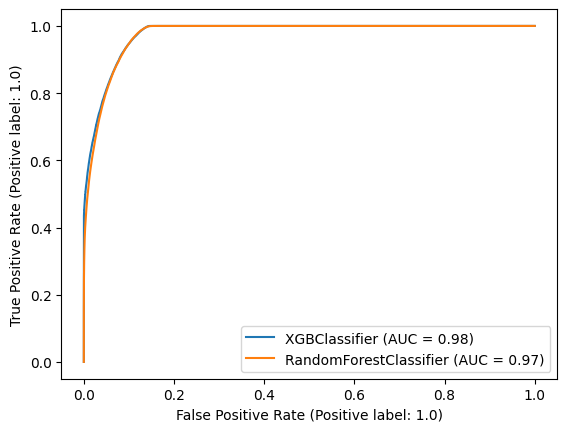

In [ ]:
disp = ConfusionMatrixDisplay.from_estimator(rf_clf, X_test, y_test,
                             cmap='Blues', values_format='d',
                             display_labels=['Default', 'Fully-Paid'])

disp = RocCurveDisplay.from_estimator(xgb_clf, X_test, y_test)
RocCurveDisplay.from_estimator(rf_clf, X_test, y_test, ax=disp.ax_)

In [ ]:
scores_dict['Random Forest'] = {
        'Train': roc_auc_score(y_train, rf_clf.predict(X_train)),
        'Test': roc_auc_score(y_test, rf_clf.predict(X_test)),
    }

# 📊 Comparing Models Prerformance

In [ ]:
ml_models = {
    'Random Forest': rf_clf,
    'XGBoost': xgb_clf,
    'ANNs': model
}

for model in ml_models:
    print(f"{model.upper():{30}} roc_auc_score: {roc_auc_score(y_test, ml_models[model].predict(X_test)):.3f}")

RANDOM FOREST                  roc_auc_score: 0.930
XGBOOST                        roc_auc_score: 0.929
6553/6553 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
ANNS                           roc_auc_score: 0.500


In [ ]:
scores_df = pd.DataFrame(scores_dict)
scores_df.hvplot.barh(
    width=500, height=400,
    title="ROC Scores of ML Models", xlabel="ROC Scores",
    alpha=0.4, legend='top'
)

:Bars   [index,Variable]   (value)

In [ ]:
scores_df

,ANNs,XGBoost,Random Forest
Train,0.91,0.93,1.00
Test,0.91,0.93,0.93
